# imports & catalogues

In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.table import join
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.coordinates import SkyCoord
from scipy.optimize import linear_sum_assignment
import all_fctns

SAMI_Target_catalogues = ("InputCatGAMADR3.fits", "InputCatClustersDR3.fits", "InputCatFiller.fits")
SAMI_regions = {0: "GAMA", 1: "Clusters", 2: "Filler"}

Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Honours Project\\"
catalogue_filepath = Source_dir + "Catalogues\\"
SAMI_regions = ("Cluster", "Filler", "GAMA")
SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
SAMI_SFR_catalogue = "AR2022_SAMI_DR3_Mstar_SFR_GSWL_rescaled.fits"
SAMI_AGN_summary_catalogue = "Crossmatched\\SAMI_AGN_matches.fits"
SAMI_cubeobs_catalogue = "CubeObs.fits"

shared_catalogue_filepath = Source_dir +  "SAMI_TOOLS_SMC_MSPA4681\\shared_catalogues\\"
gassig_statistics_catalogue = "gassig_statistics.fits"

def refresh_module():
    import importlib
    import all_fctns
    importlib.reload(all_fctns)


with fits.open(catalogue_filepath + "\\Crossmatched\\SAMI_AGN_matches.fits") as SAMI_AGN_matches_hdul:
    Summary_table_hdu = Table(SAMI_AGN_matches_hdul[1].data)

with fits.open(catalogue_filepath + SAMI_SFR_catalogue) as SAMI_SFR_hdul:
    SAMI_SFR_table_hdu = Table(SAMI_SFR_hdul[1].data)

with fits.open(catalogue_filepath + SAMI_spectra_catalogue) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

with fits.open(catalogue_filepath + SAMI_cubeobs_catalogue) as SAMI_CubeObs_hdul:
    SAMI_CubeObs_table_hdu =  Table(SAMI_CubeObs_hdul[1].data)

with fits.open(shared_catalogue_filepath + gassig_statistics_catalogue) as gassig_statistics_hdul:
    gassig_statistics_table = Table(gassig_statistics_hdul[1].data)

AGN_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 7, 8, 9, 10])
HII_Composite_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [0, 1, 2])
possible_AGN_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [3, 4, 5])
inconclusive_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [-1, 999999])
na_mask = Summary_table_hdu['CATEGORY_BPT_AGN'] == 999999


AGN_CATIDs = Summary_table_hdu['CATID'][AGN_mask]
HII_Composite_CATIDs = Summary_table_hdu['CATID'][HII_Composite_mask]

AGN_colour = 'red'
HII_Composite_colour = 'blue'
possible_AGN_colour = 'orange'
inconclusive_colour = 'grey'


BPT_classification_dict = {'AGN BPT': (AGN_mask, AGN_colour),
                            'Possible AGN BPT': (possible_AGN_mask, possible_AGN_colour),
                           'HII/Composite': (HII_Composite_mask, HII_Composite_colour),
                           'Inconclusive': (inconclusive_mask, inconclusive_colour)}

BPT_classification_dict_handles = {key: plt.Line2D([0], [0], marker='o', color='w', label=key, linestyle='None', markersize=10, markerfacecolor=value[1]) for key, value in BPT_classification_dict.items()} # for the legends


radiosource_mask = Summary_table_hdu['IS_RADIOSOURCE'] ==1
xraysource_mask = Summary_table_hdu['IS_XRAYSOURCE'] == 1
HERG_mask = Summary_table_hdu['IS_HERG'] == 1
LERG_mask = Summary_table_hdu['IS_HERG'] == 0

radiosource_only_mask = radiosource_mask & ~xraysource_mask
xraysource_only_mask = xraysource_mask & ~radiosource_mask
xray_and_radiosource_mask = radiosource_mask & xraysource_mask
nosource_mask = ~radiosource_mask & ~xraysource_mask


nosource_marker  = 'o'
radiosource_marker = '|'
xraysource_marker = '_'
xray_and_radiosource_marker = '+'

radiosource_linestyle = '--'
xraysource_linestyle = '-.'
xray_and_radiosource_linestyle = ':'

nosource_colour = 'grey'
radiosource_colour = 'lime'
xraysource_colour = 'dodgerblue'
xray_and_radiosource_colour = 'turquoise'


# Define a dictionary to hold the source type information. Format is: source_type_dict = {'Source Type': (mask, marker, linestyle, point_size, colour)}
source_type_dict = {'Radio and X-ray Source': (xray_and_radiosource_mask, xray_and_radiosource_marker, xray_and_radiosource_linestyle, 20, xray_and_radiosource_colour),
                    'Only Radio Source': (radiosource_only_mask, radiosource_marker, radiosource_linestyle, 20, radiosource_colour),
                    'Only X-ray Source': (xraysource_only_mask, xraysource_marker, xraysource_linestyle, 20, xraysource_colour),
                    'No Match': ( nosource_mask, nosource_marker, '-' , 2, nosource_colour),}

source_type_dict_handles = {key: plt.Line2D([0], [0], marker=value[1], color='k', label=key, markersize=10, linestyle='None') for key, value in source_type_dict.items()} # for the legends



# radio/AGN dictionary
AGN_and_radiosource_mask = radiosource_mask & (AGN_mask | possible_AGN_mask) #HERG
AGN_and_not_radiosource_mask = (AGN_mask | possible_AGN_mask) & ~radiosource_mask
not_AGN_and_radiosource_mask = radiosource_mask & ~(AGN_mask | possible_AGN_mask)
not_AGN_and_not_radiosource_mask = ~radiosource_mask & ~(AGN_mask | possible_AGN_mask)

HERG_colour = AGN_colour
LERG_colour = inconclusive_colour

radiosource_AGN_dict = {'HERG': (HERG_mask, AGN_colour, radiosource_marker, radiosource_linestyle, 20),
                        'Radio-quiet AGN': (AGN_and_not_radiosource_mask, AGN_colour, nosource_marker, '-', 2),
                        'LERG': (LERG_mask, inconclusive_colour, radiosource_marker, radiosource_linestyle, 20),
                        'Not AGN BPT & Radio-quiet': (not_AGN_and_not_radiosource_mask, inconclusive_colour, nosource_marker, '-', 2)}


LINER_colour = 'green'
radiosource_LINER_dict = {'Radio-loud LINER': (AGN_and_radiosource_mask, LINER_colour, radiosource_marker, radiosource_linestyle, 20),
                        'Radio-quiet LINER': (AGN_and_not_radiosource_mask, LINER_colour, nosource_marker, '-', 2),
                     #   'LERG': (not_AGN_and_radiosource_mask, inconclusive_colour, radiosource_marker, radiosource_linestyle, 20),
                        'Not AGN BPT & Radio-quiet': (not_AGN_and_not_radiosource_mask, inconclusive_colour, nosource_marker, '-', 2)}


radioAGN_colour = 'red'
nonradioAGN_colour = 'blue'
radioNonAGN_colour = 'dodgerblue'
nonradioNonAGN_colour = 'green'

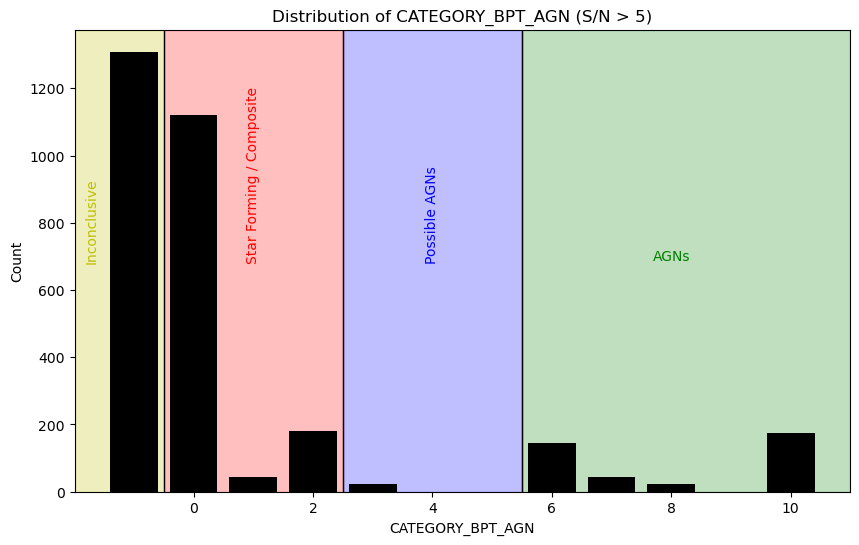

Number of AGN (CATEGORY_BPT_AGN > 5):  386
Number of LINERs (5 <= CATEGORY_BPT_AGN <= 6):  146
Number of Seyferts (7 <= CATEGORY_BPT_AGN <= 10):  43
Number of OIII AGN (8 <= CATEGORY_BPT_AGN <= 10):  23
Number of Possible AGN (3 <= CATEGORY_BPT_AGN <= 5):  23
Number of HII/Composite (0 <= CATEGORY_BPT_AGN <= 2):  1349
Number of Inconclusive (-1 <= CATEGORY_BPT_AGN <= 2):  1310


In [2]:
# Get the column as a numpy array
categories = np.array(Summary_table_hdu['CATEGORY_BPT_AGN'])

# Count occurrences of each unique value
unique, counts = np.unique(categories, return_counts=True)
# remove weird 999999 value
mask = unique != 999999
unique = unique[mask]
counts = counts[mask]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(unique, counts)
plt.xlabel('CATEGORY_BPT_AGN')
plt.ylabel('Count')
plt.title('Distribution of CATEGORY_BPT_AGN (S/N > 5)')

xlims = plt.xlim()
ylims = plt.ylim()

plt.xlim(xlims[0], xlims[1])
plt.ylim(ylims[0], ylims[1])

plt.axvline(x=5.5, color='black', linewidth=1)
plt.fill_betweenx([0, ylims[1]], 5.5, xlims[1], color='g', alpha=0.25, label='AGNs')
plt.text(8, 0.5*ylims[1], 'AGNs', color='g', fontsize=10, ha='center')

plt.axvline(x=2.5, color='black', linewidth=1)
plt.fill_betweenx([0, ylims[1]], 2.5, 5.5, color='b', alpha=0.25, label='Possible AGNs')
plt.text(4, 0.5*ylims[1], 'Possible AGNs', color='b', fontsize=10, ha='center', rotation='vertical')

plt.axvline(x=-0.5, color='black', linewidth=1)
plt.fill_betweenx([0, ylims[1]], -0.5, 2.5, color='r', alpha=0.25, label='Star Forming / Composite')
plt.text(1, 0.5*ylims[1], 'Star Forming / Composite', color='r', fontsize=10, ha='center', rotation='vertical')

plt.fill_betweenx([0, ylims[1]], xlims[0], -0.5, color='y', alpha=0.25, label='Inconclusive')
plt.text(-1.7, 0.5*ylims[1], 'Inconclusive', color='y', fontsize=10, ha='center', rotation='vertical')

plt.bar(unique, counts, color='black')

plt.show()


print("Number of AGN (CATEGORY_BPT_AGN > 5): ", np.sum(AGN_mask))
print("Number of LINERs (5 <= CATEGORY_BPT_AGN <= 6): ", np.sum(Summary_table_hdu['CATEGORY_BPT_AGN'] == 6))
print("Number of Seyferts (7 <= CATEGORY_BPT_AGN <= 10): ", np.sum(Summary_table_hdu['CATEGORY_BPT_AGN'] == 7))
print("Number of OIII AGN (8 <= CATEGORY_BPT_AGN <= 10): ", np.sum(Summary_table_hdu['CATEGORY_BPT_AGN'] == 8))
print("Number of Possible AGN (3 <= CATEGORY_BPT_AGN <= 5): ", np.sum(possible_AGN_mask))
print("Number of HII/Composite (0 <= CATEGORY_BPT_AGN <= 2): ", np.sum(HII_Composite_mask))
print("Number of Inconclusive (-1 <= CATEGORY_BPT_AGN <= 2): ", np.sum(inconclusive_mask))
# print("Number of N/A (CATEGORY_BPT_AGN = 999999): ", np.sum(na_mask))

In [3]:
# make a table of the AGN BPT statistics
column_names = ['Category', 'Count']
data = [
    ['AGN BPT', np.sum(AGN_mask)],
    ['LINERs (5 <= CATEGORY_BPT_AGN <= 6)', np.sum(Summary_table_hdu['CATEGORY_BPT_AGN'] == 6)],
    ['Seyferts (7 <= CATEGORY_BPT_AGN <= 10)', np.sum(Summary_table_hdu['CATEGORY_BPT_AGN'] == 7)],
    ['NII cutoff AGN (8 <= CATEGORY_BPT_AGN <= 10)', np.sum(Summary_table_hdu['CATEGORY_BPT_AGN'] == 10)],
    ['Possible AGN (3 <= CATEGORY_BPT_AGN <= 5)', np.sum(possible_AGN_mask)],
    ['HII/Composite (0 <= CATEGORY_BPT_AGN <= 2)', np.sum(HII_Composite_mask)],
    ['Inconclusive (-1 <= CATEGORY_BPT_AGN <= 2)', np.sum(inconclusive_mask)],
   # ['N/A (CATEGORY_BPT_AGN = 999999)', np.sum(na_mask)]
]

AGN_statistics_table = Table(rows=data, names=column_names)
AGN_statistics_table

Category,Count
str44,int64
AGN BPT,386
LINERs (5 <= CATEGORY_BPT_AGN <= 6),146
Seyferts (7 <= CATEGORY_BPT_AGN <= 10),43
NII cutoff AGN (8 <= CATEGORY_BPT_AGN <= 10),174
Possible AGN (3 <= CATEGORY_BPT_AGN <= 5),23
HII/Composite (0 <= CATEGORY_BPT_AGN <= 2),1349
Inconclusive (-1 <= CATEGORY_BPT_AGN <= 2),1310


# M_STAR investigation

## M_STAR v SFR plot

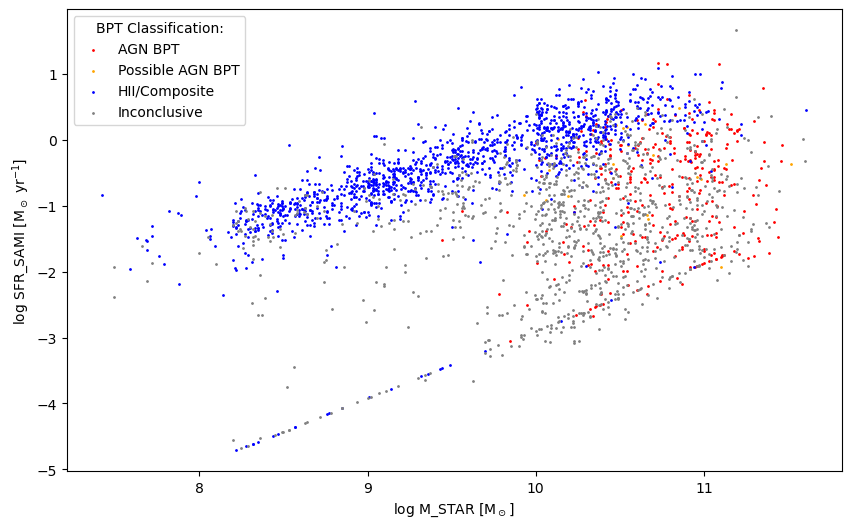

In [6]:
M_STAR_array = Summary_table_hdu['M_STAR']
SFR_SAMI_array = Summary_table_hdu['SFR_SAMI']

plt.figure(figsize=(10, 6))

for category, (mask, colour) in BPT_classification_dict.items():

    if np.any(mask):
        plt.scatter(M_STAR_array[mask], SFR_SAMI_array[mask], s=1, label=category, color=colour)

plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('log SFR_SAMI [M$_\\odot$ yr$^{-1}$]')

plt.legend(title='BPT Classification:')

### w/ source type

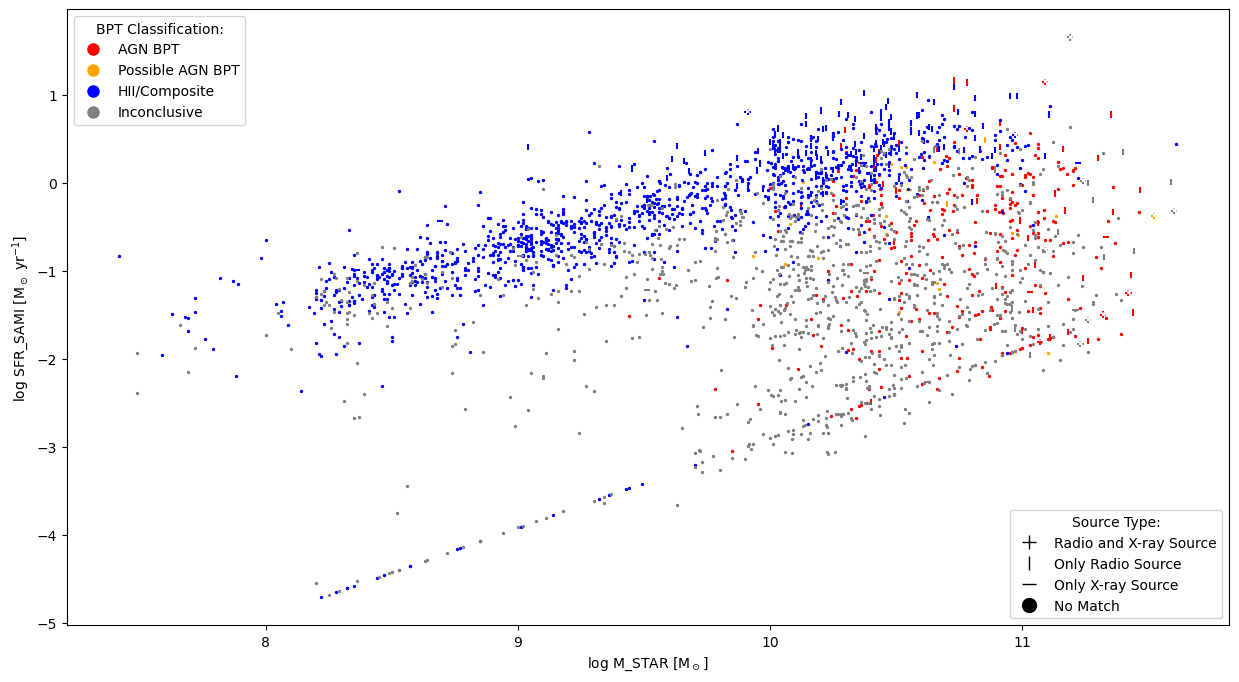

In [7]:
M_STAR_array = Summary_table_hdu['M_STAR']
SFR_SAMI_array = Summary_table_hdu['SFR_SAMI']

plt.figure(figsize=(15, 8))

for category, (bpt_mask, colour) in BPT_classification_dict.items():
    # radio and x-ray sources
    for source_type, (source_mask, marker, linestyle, point_size, _) in source_type_dict.items():
        mask = bpt_mask & source_mask
        if np.any(mask):
            plt.scatter(M_STAR_array[mask], SFR_SAMI_array[mask], s=point_size, color=colour, marker=marker, linestyle=linestyle)

plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('log SFR_SAMI [M$_\\odot$ yr$^{-1}$]')

# get both legends
legend1 = plt.legend(handles=[BPT_classification_dict_handles[key] for key in BPT_classification_dict.keys()], title='BPT Classification:', loc='upper left')
legend2 = plt.legend(handles=[source_type_dict_handles[key] for key in source_type_dict.keys()], title='Source Type:', loc='lower right')

plt.gca().add_artist(legend1)  # Add the first legend to the plot
plt.show()

### w/ Radio/Non-Radio, AGN/non-AGN

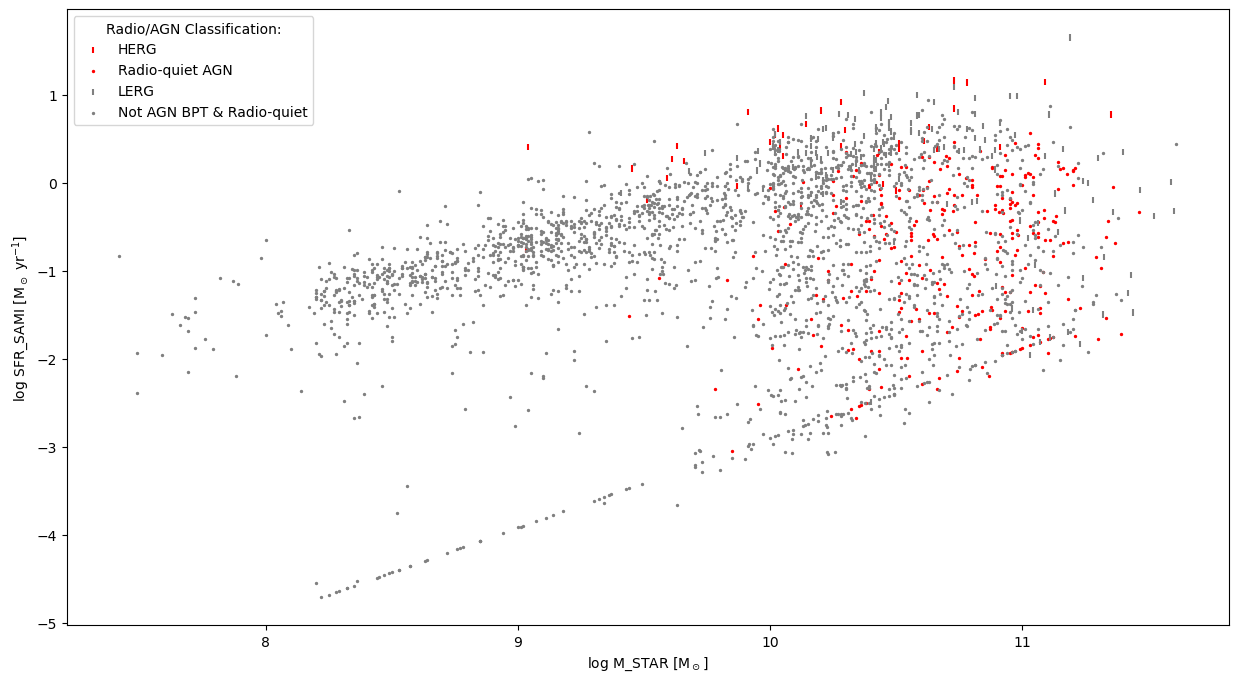

In [8]:
M_STAR_array = Summary_table_hdu['M_STAR']
SFR_SAMI_array = Summary_table_hdu['SFR_SAMI']

plt.figure(figsize=(15, 8))
for category, (mask, colour, marker, linestyle, point_size) in radiosource_AGN_dict.items():
    if np.any(mask):
        plt.scatter(M_STAR_array[mask], SFR_SAMI_array[mask], s=point_size, color=colour, marker=marker, linestyle=linestyle, label=category)

plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('log SFR_SAMI [M$_\\odot$ yr$^{-1}$]')
plt.legend(title='Radio/AGN Classification:')
plt.show()

## Mass Distributions

### BPT classification

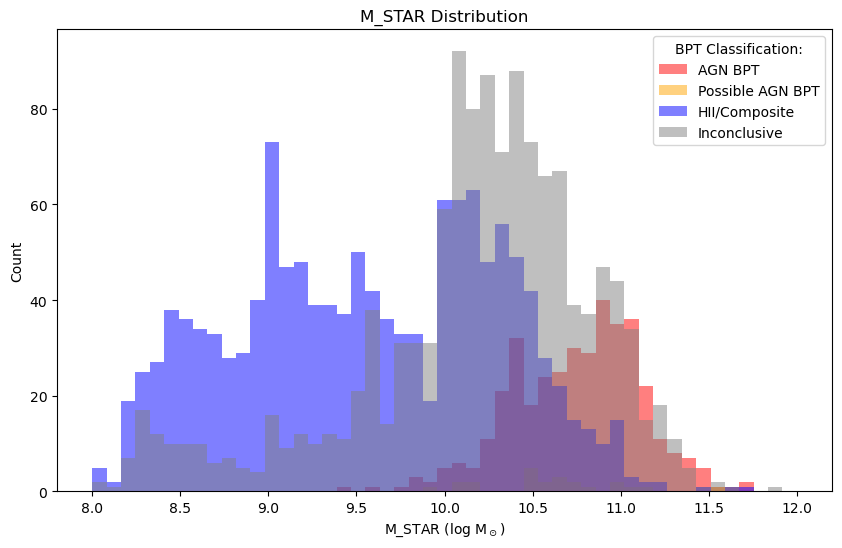

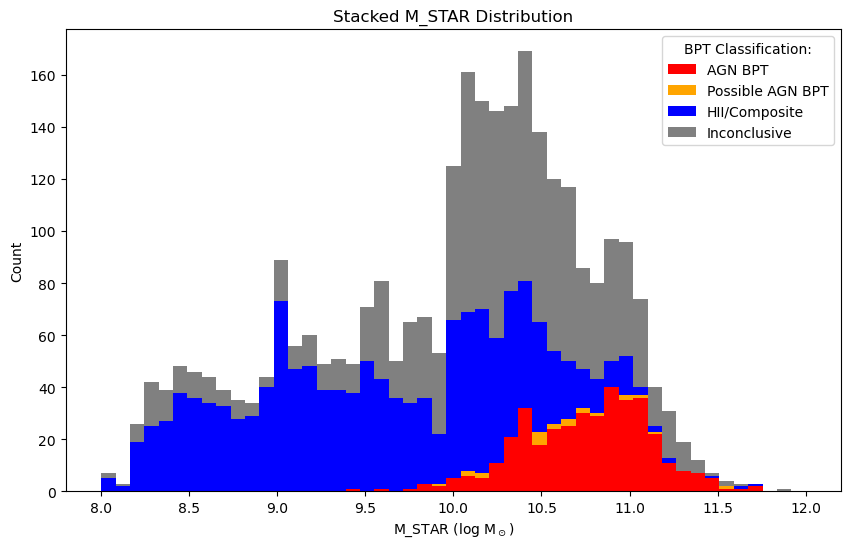

In [73]:
bins = np.linspace(8, 12, 50)

plt.figure(figsize=(10, 6))

for category, (mask, colour) in BPT_classification_dict.items():
    if np.any(mask):
        plt.hist(M_STAR_array[mask], bins=bins, label=category, alpha=0.5, color=colour)

plt.xlabel('M_STAR (log M$_\\odot$)')
plt.ylabel('Count')
plt.title('M_STAR Distribution')
plt.legend(title='BPT Classification:')

plt.show()


plt.figure(figsize=(10, 6))
M_STAR_ls = []
for category, (mask, colour) in BPT_classification_dict.items():
    M_STAR_ls.append(M_STAR_array[mask])
plt.hist(M_STAR_ls, bins=bins, label=BPT_classification_dict.keys(), stacked=True, color=[BPT_classification_dict[cat][1] for cat in BPT_classification_dict.keys()])
plt.xlabel('M_STAR (log M$_\\odot$)')
plt.ylabel('Count')
plt.title('Stacked M_STAR Distribution')
plt.legend(title='BPT Classification:')

plt.show()

### Source Type

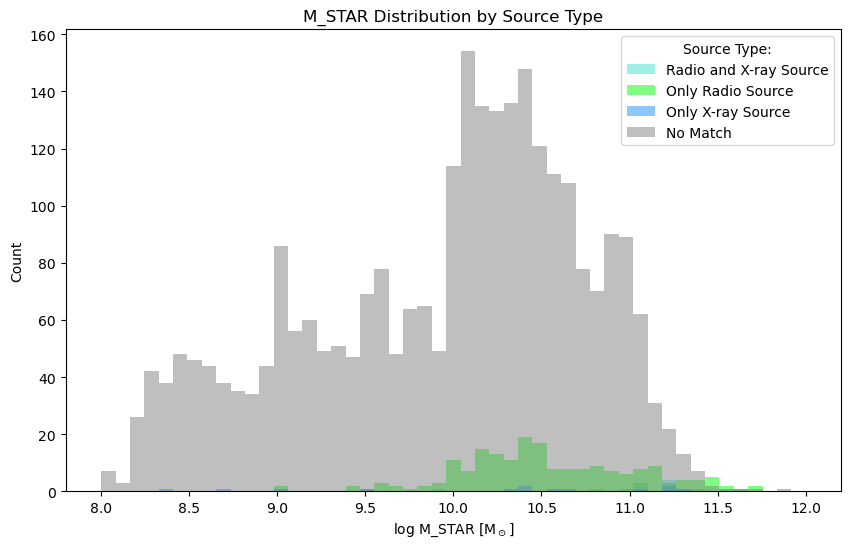

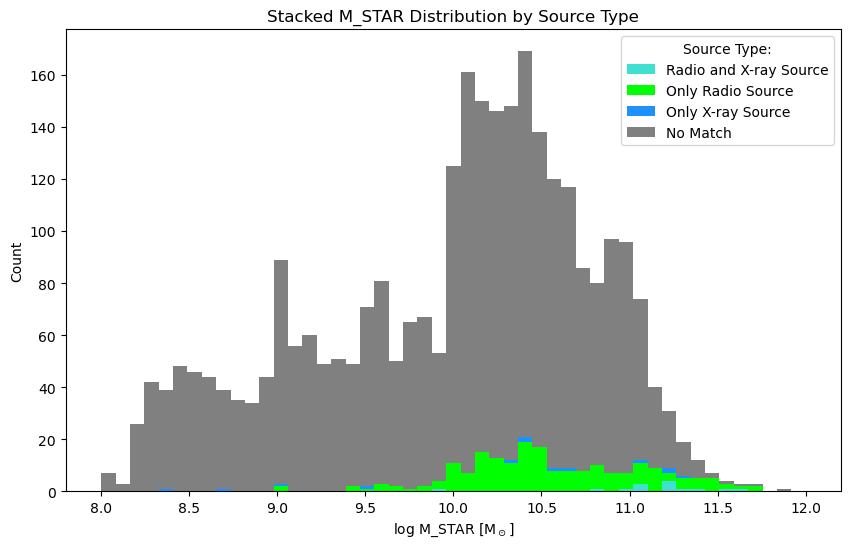

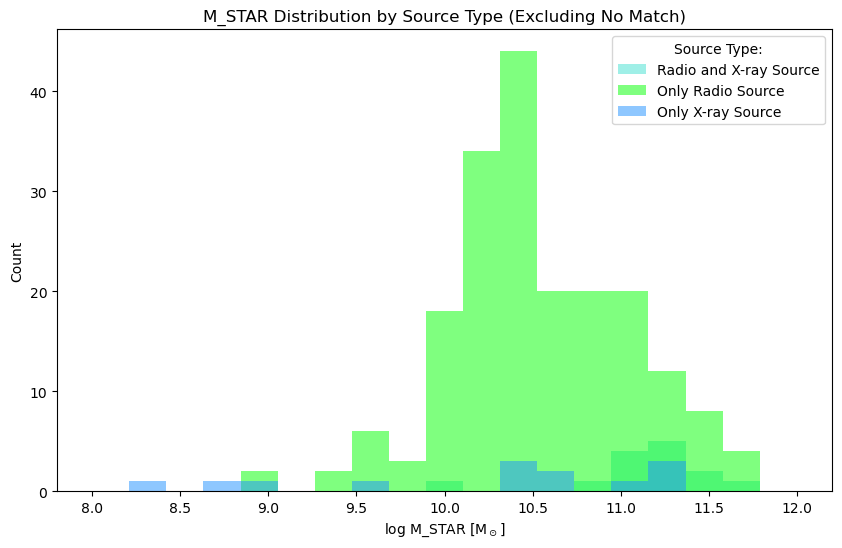

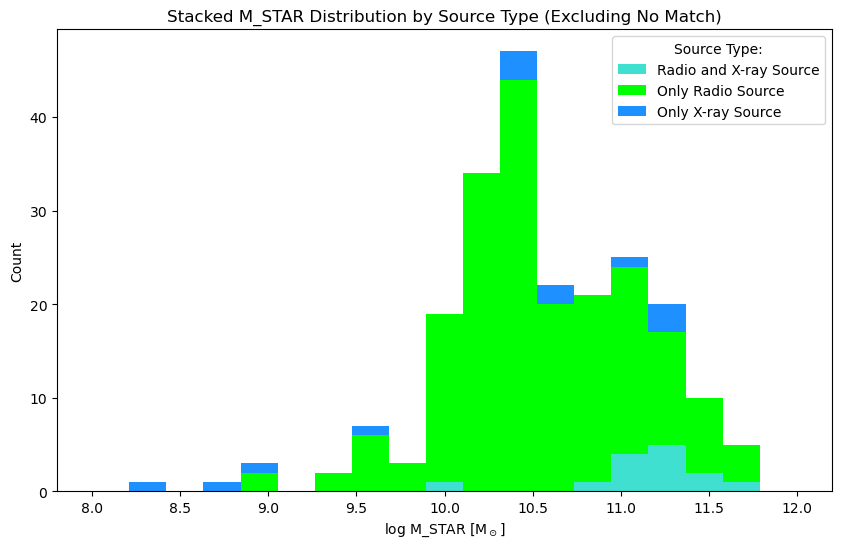

In [10]:
bins = np.linspace(8, 12, 50)

plt.figure(figsize=(10, 6))

for category, (source_mask, marker, linestyle, point_size, colour) in source_type_dict.items():
    mask = source_mask
    if np.any(mask):
        plt.hist(M_STAR_array[mask], bins=bins, label=category, alpha=0.5, color=colour, linestyle=linestyle)

plt.title('M_STAR Distribution by Source Type')
plt.legend(title='Source Type:')
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
M_STAR_ls = []
for category, (source_mask, marker, linestyle, point_size, colour) in source_type_dict.items():
    M_STAR_ls.append(M_STAR_array[source_mask])
plt.hist(M_STAR_ls, bins=bins, label=source_type_dict.keys(), stacked=True, color=[source_type_dict[cat][4] for cat in source_type_dict.keys()])
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('Count')
plt.title('Stacked M_STAR Distribution by Source Type')
plt.legend(title='Source Type:')

bins = np.linspace(8, 12, 20)



plt.figure(figsize=(10, 6))

for category, (source_mask, marker, linestyle, point_size, colour) in source_type_dict.items():
    mask = source_mask
    if category == 'No Match':
        continue
    if np.any(mask):
        plt.hist(M_STAR_array[mask], bins=bins, label=category, alpha=0.5, color=colour, linestyle=linestyle)
plt.title('M_STAR Distribution by Source Type (Excluding No Match)')
plt.legend(title='Source Type:')
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
M_STAR_ls = []
for category, (source_mask, marker, linestyle, point_size, colour) in source_type_dict.items():
    if category == 'No Match':
        continue
    M_STAR_ls.append(M_STAR_array[source_mask])
plt.hist(M_STAR_ls, bins=bins, label=source_type_dict.keys(), stacked=True, color=[source_type_dict[cat][4] for cat in source_type_dict.keys() if cat != 'No Match'])
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('Count')
plt.title('Stacked M_STAR Distribution by Source Type (Excluding No Match)')
plt.legend(title='Source Type:')
plt.show()



### Radio/AGN

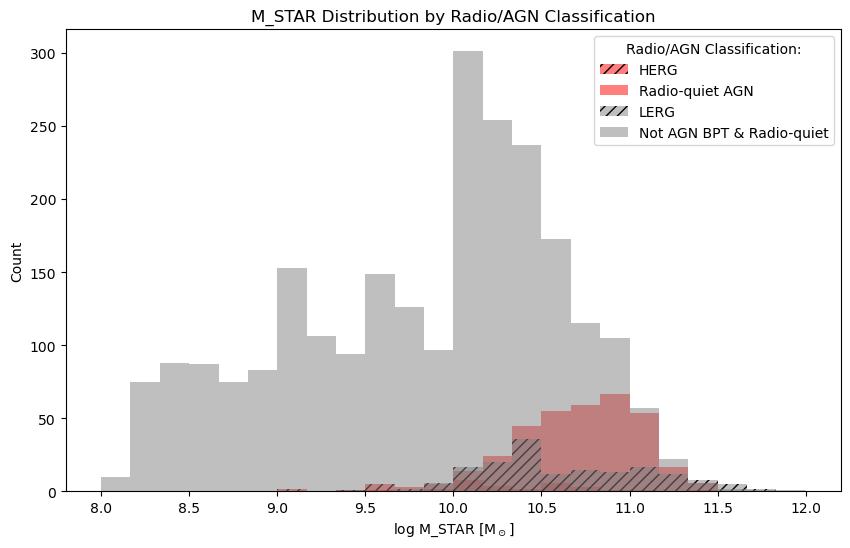

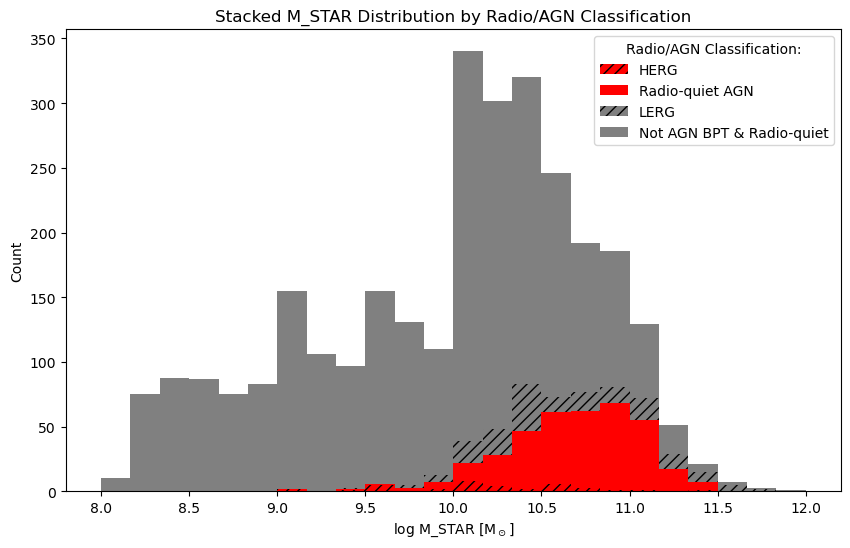

In [11]:
nbins = 25
bins = np.linspace(8, 12, nbins)

plt.figure(figsize=(10, 6))
for category, (mask, colour, marker, linestyle, point_size) in radiosource_AGN_dict.items():
    if np.any(mask):
        hatch = '///' if linestyle == radiosource_linestyle else None
        plt.hist(M_STAR_array[mask], bins=bins, label=category, alpha=0.5, color=colour, linestyle=linestyle, hatch=hatch)
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('Count')
plt.title('M_STAR Distribution by Radio/AGN Classification')
plt.legend(title='Radio/AGN Classification:')
plt.show()

plt.figure(figsize=(10, 6))
M_STAR_ls = []
for category, (mask, colour, marker, linestyle, point_size) in radiosource_AGN_dict.items():
    M_STAR_ls.append(M_STAR_array[mask])
plt.hist(M_STAR_ls, bins=bins, label=radiosource_AGN_dict.keys(), stacked=True, color=[radiosource_AGN_dict[cat][1] for cat in radiosource_AGN_dict.keys()], hatch=[None if radiosource_AGN_dict[cat][3] == '-' else '///' for cat in radiosource_AGN_dict.keys()])
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('Count')
plt.title('Stacked M_STAR Distribution by Radio/AGN Classification')
plt.legend(title='Radio/AGN Classification:')
plt.show()

## AGN Mass percentage distribution

### line-plot

#### BPT classifications

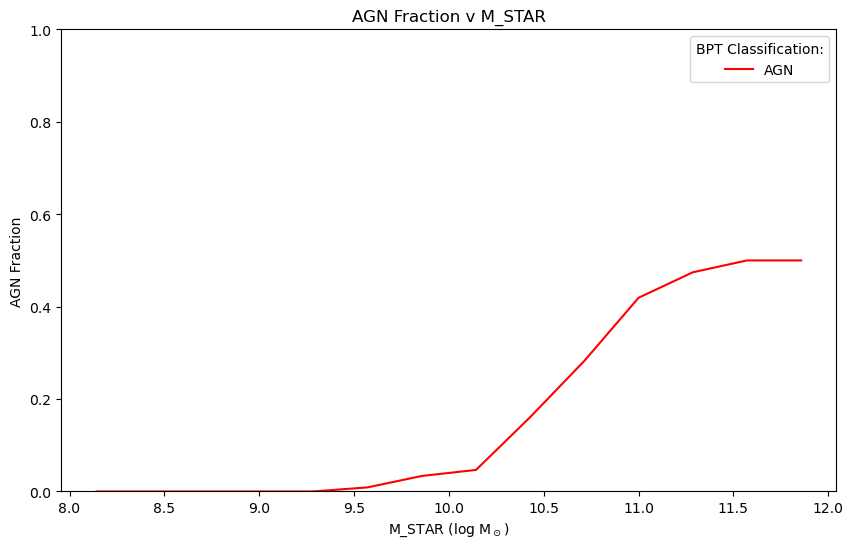

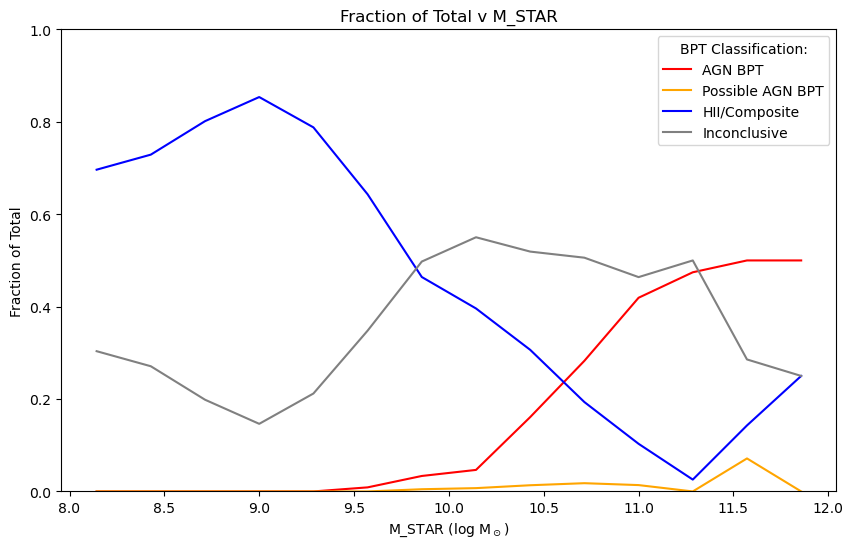

In [71]:
nbins = 15
bins = np.linspace(8, 12, nbins)
total_counts, _ = np.histogram(M_STAR_array, bins=bins)

plt.figure(figsize=(10, 6))
AGN_counts, _ = np.histogram(M_STAR_array[AGN_mask], bins=bins)
plt.plot(bins[:-1]+np.diff(bins)/2, AGN_counts / total_counts, label='AGN', color=AGN_colour, linestyle='-')

plt.xlabel('M_STAR (log M$_\\odot$)')
plt.ylabel('AGN Fraction')
plt.ylim((0,1))
plt.legend(title='BPT Classification:')
plt.title('AGN Fraction v M_STAR')
plt.show()



plt.figure(figsize=(10, 6))

for category, (mask, colour) in BPT_classification_dict.items():
    category_counts, _ = np.histogram(M_STAR_array[mask], bins=bins)
    plt.plot(bins[:-1]+np.diff(bins)/2, category_counts / total_counts, label=category, color=colour, linestyle='-')

plt.xlabel('M_STAR (log M$_\\odot$)')
plt.ylabel('Fraction of Total')
plt.ylim((0,1))
plt.legend(title='BPT Classification:')
plt.title('Fraction of Total v M_STAR')
plt.show()

#### Source Types

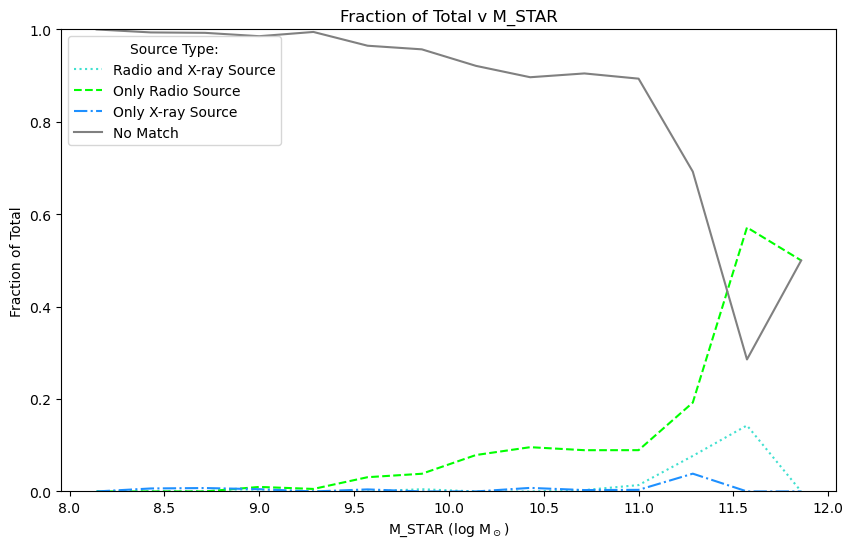

In [13]:
plt.figure(figsize=(10, 6))

nbins = 15
bins = np.linspace(8, 12, nbins)
total_counts, _ = np.histogram(M_STAR_array, bins=bins)

for source_type, (source_mask, marker, linestyle, point_size, colour) in source_type_dict.items():
    source_counts, _ = np.histogram(M_STAR_array[source_mask], bins=bins)
    plt.plot(bins[:-1]+np.diff(bins)/2, source_counts / total_counts, label=source_type, color=colour, linestyle=linestyle)

plt.xlabel('M_STAR (log M$_\\odot$)')
plt.ylabel('Fraction of Total')
plt.ylim((0,1))
plt.legend(title='Source Type:')
plt.title('Fraction of Total v M_STAR')
plt.show()

#### Radio/AGN 

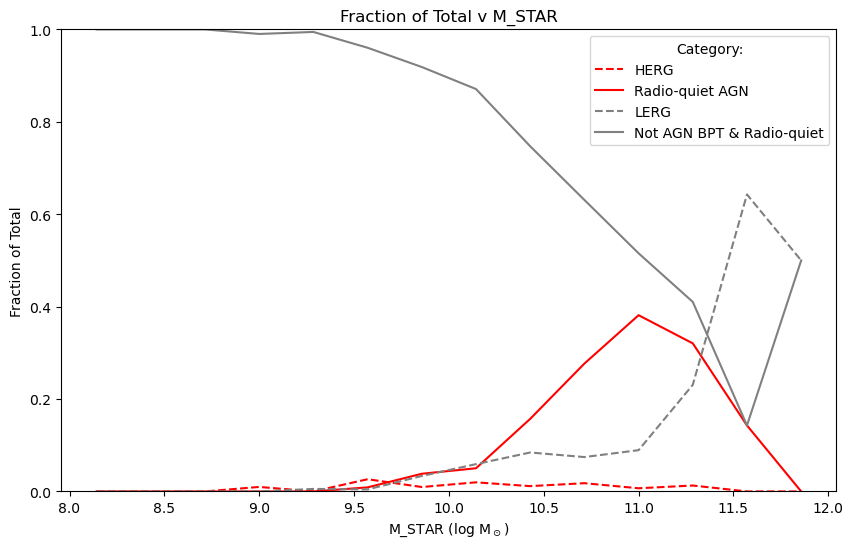

In [72]:
plt.figure(figsize=(10, 6))

nbins = 15
bins = np.linspace(8, 12, nbins)
total_counts, _ = np.histogram(M_STAR_array, bins=bins)

for category, (mask, colour, marker, linestyle, point_size) in radiosource_AGN_dict.items():
    category_counts, _ = np.histogram(M_STAR_array[mask], bins=bins)
    plt.plot(bins[:-1]+np.diff(bins)/2, category_counts / total_counts, label=category, color=colour, linestyle=linestyle)


plt.xlabel('M_STAR (log M$_\\odot$)')
plt.ylabel('Fraction of Total')
plt.ylim((0,1))
plt.legend(title='Category:')
plt.title('Fraction of Total v M_STAR')
plt.show()

#### Percentage of Radio AGN, X-Ray AGN out of all AGN

C:\Users\mspan\AppData\Local\Temp\ipykernel_4708\867279901.py:10: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins[:-1]+np.diff(bins)/2, category_counts / total_counts, label=category, color=colour, linestyle=linestyle)


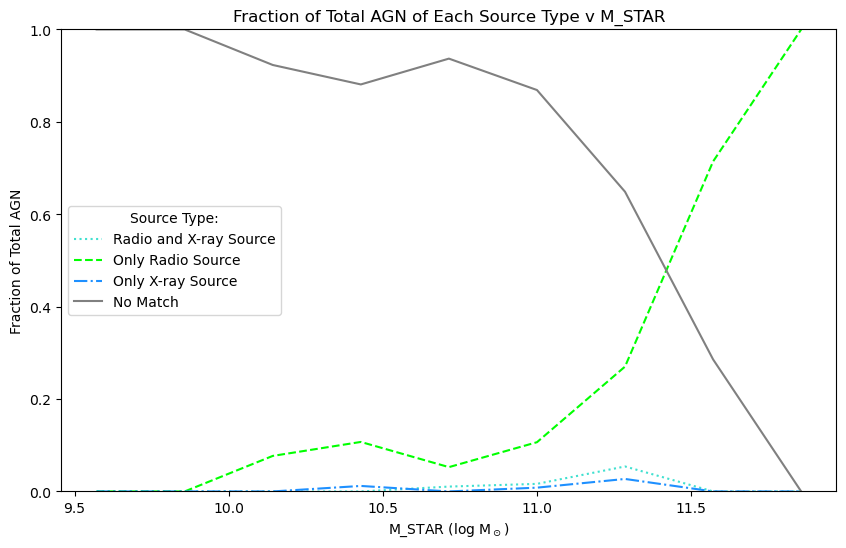

In [15]:
nbins = 15
bins = np.linspace(8, 12, nbins)

total_counts, _ = np.histogram(M_STAR_array[AGN_mask], bins=bins)

plt.figure(figsize=(10, 6))
for category, (source_mask, marker, linestyle, point_size, colour) in source_type_dict.items():
    mask = AGN_mask & source_mask
    category_counts, _ = np.histogram(M_STAR_array[mask], bins=bins)
    plt.plot(bins[:-1]+np.diff(bins)/2, category_counts / total_counts, label=category, color=colour, linestyle=linestyle)

plt.title('Fraction of Total AGN of Each Source Type v M_STAR')
plt.xlabel('M_STAR (log M$_\\odot$)')
plt.ylabel('Fraction of Total AGN')
plt.ylim((0,1))
plt.legend(title='Source Type:')

### bar-plot

#### BPT classifications

(8.0, 12.0)

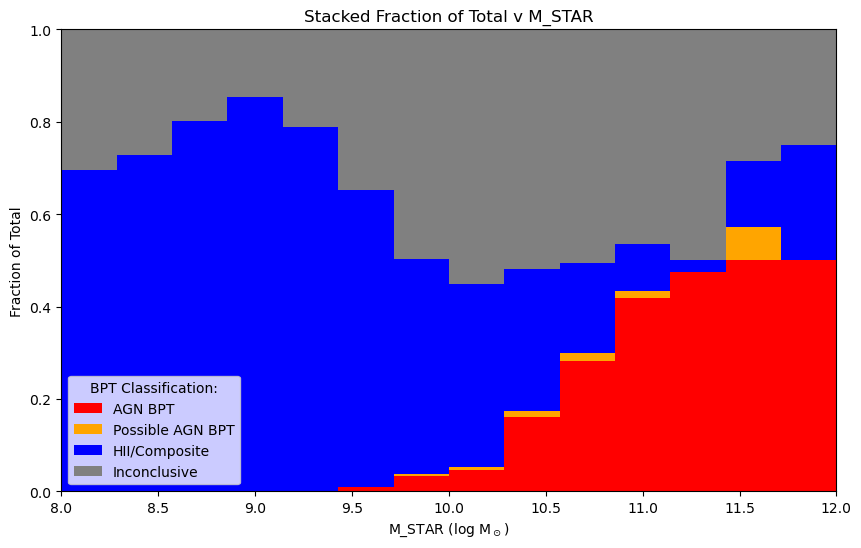

In [16]:
nbins = 15
bins = np.linspace(8, 12, nbins)

binwidth = np.diff(bins)
total_counts, _ = np.histogram(M_STAR_array, bins=bins)

plt.figure(figsize=(10, 6))
other_counts = np.zeros_like(total_counts)
for category, (mask, colour) in BPT_classification_dict.items():
    category_counts, _ = np.histogram(M_STAR_array[mask], bins=bins)
    plt.bar(bins[:-1]+np.diff(bins)/2, category_counts / total_counts, width=np.diff(bins), label=category, color=colour, bottom=other_counts)
    other_counts = other_counts + category_counts / total_counts

plt.legend(title='BPT Classification:')
plt.xlabel('M_STAR (log M$_\\odot$)')
plt.ylabel('Fraction of Total')
plt.title('Stacked Fraction of Total v M_STAR')
plt.ylim((0,1))
plt.xlim((8, 12))

#### Source Types

C:\Users\mspan\AppData\Local\Temp\ipykernel_4708\1161553497.py:37: RuntimeWarning: invalid value encountered in divide
  plt.bar(bins[:-1]+np.diff(bins)/2, source_counts / total_counts, width=np.diff(bins), label=source_type, color=colour, bottom=other_counts)
C:\Users\mspan\AppData\Local\Temp\ipykernel_4708\1161553497.py:38: RuntimeWarning: invalid value encountered in divide
  other_counts = other_counts + source_counts / total_counts


(8.0, 12.0)

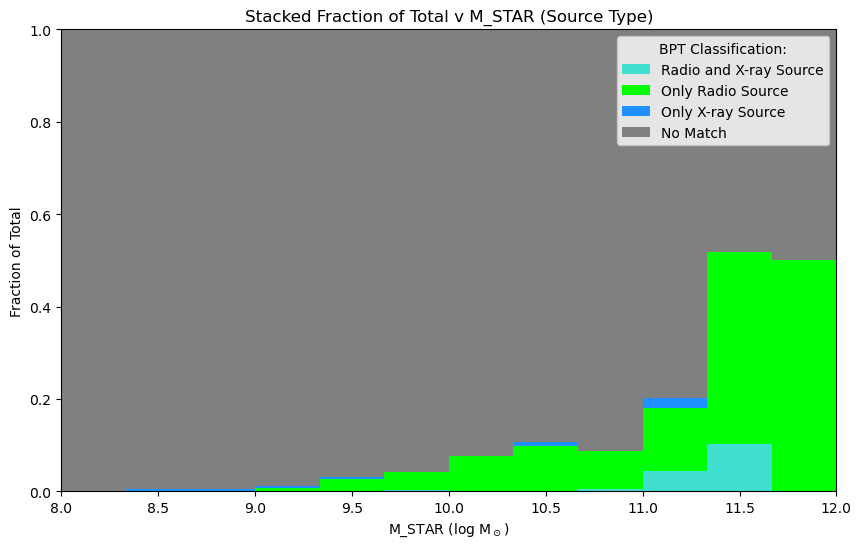

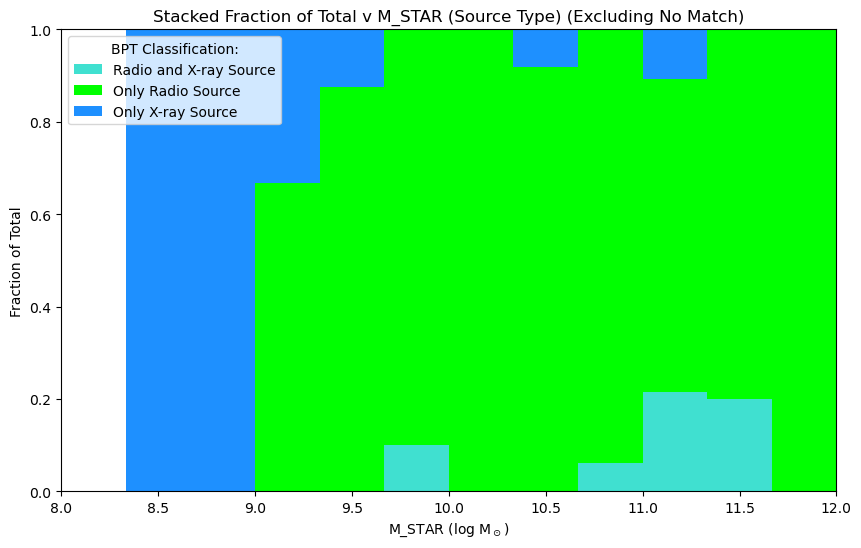

In [17]:
nbins = 13
bins = np.linspace(8, 12, nbins)

binwidth = np.diff(bins)
total_counts, _ = np.histogram(M_STAR_array, bins=bins)

plt.figure(figsize=(10, 6))
other_counts = np.zeros_like(total_counts)
for source_type, (source_mask, marker, linestyle, point_size, colour) in source_type_dict.items():
    source_counts, _ = np.histogram(M_STAR_array[source_mask], bins=bins)
    plt.bar(bins[:-1]+np.diff(bins)/2, source_counts / total_counts, width=np.diff(bins), label=source_type, color=colour, bottom=other_counts)
    other_counts = other_counts + source_counts / total_counts

plt.legend(title='BPT Classification:')
plt.xlabel('M_STAR (log M$_\\odot$)')
plt.ylabel('Fraction of Total')
plt.title('Stacked Fraction of Total v M_STAR (Source Type)')
plt.ylim((0,1))
plt.xlim((8, 12))

# now without galaxies with no match
binwidth = np.diff(bins)
total_counts, _ = np.histogram(M_STAR_array, bins=bins)

# get no match counts
no_match_counts, _ = np.histogram(M_STAR_array[nosource_mask], bins=bins)

#redefine total_counts without no match
total_counts = total_counts - no_match_counts

plt.figure(figsize=(10, 6))
other_counts = np.zeros_like(total_counts)
for source_type, (source_mask, marker, linestyle, point_size, colour) in source_type_dict.items():
    if source_type == 'No Match':
        continue
    source_counts, _ = np.histogram(M_STAR_array[source_mask], bins=bins)
    plt.bar(bins[:-1]+np.diff(bins)/2, source_counts / total_counts, width=np.diff(bins), label=source_type, color=colour, bottom=other_counts)
    other_counts = other_counts + source_counts / total_counts

plt.legend(title='BPT Classification:')
plt.xlabel('M_STAR (log M$_\\odot$)')
plt.ylabel('Fraction of Total')
plt.title('Stacked Fraction of Total v M_STAR (Source Type) (Excluding No Match)')
plt.ylim((0,1))
plt.xlim((8, 12))


# GASSIG investigation

In [74]:
joined_gassig_summary_table = join(Summary_table_hdu, gassig_statistics_table, keys='CATID', join_type='left')
na_mask = np.isnan(Summary_table_hdu['M_STAR']) | np.isnan(Summary_table_hdu['SFR_SAMI'])
valid_Summary_table_hdu = Summary_table_hdu[~na_mask]

valid_AGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (6, 7, 8, 9, 10))
valid_radiosource_mask = valid_Summary_table_hdu['IS_RADIOSOURCE'] == 1
valid_HERG_mask = valid_Summary_table_hdu['IS_HERG'] == 1
valid_LERG_mask = valid_Summary_table_hdu['IS_HERG'] == 0

valid_LINER_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (6))

gassig_statistics_table

print(np.array(gassig_statistics_table['CATID'][gassig_statistics_table['MEDIAN_VEL_DISP']>400]))

[214250]


## AGN, HII/Composite matched

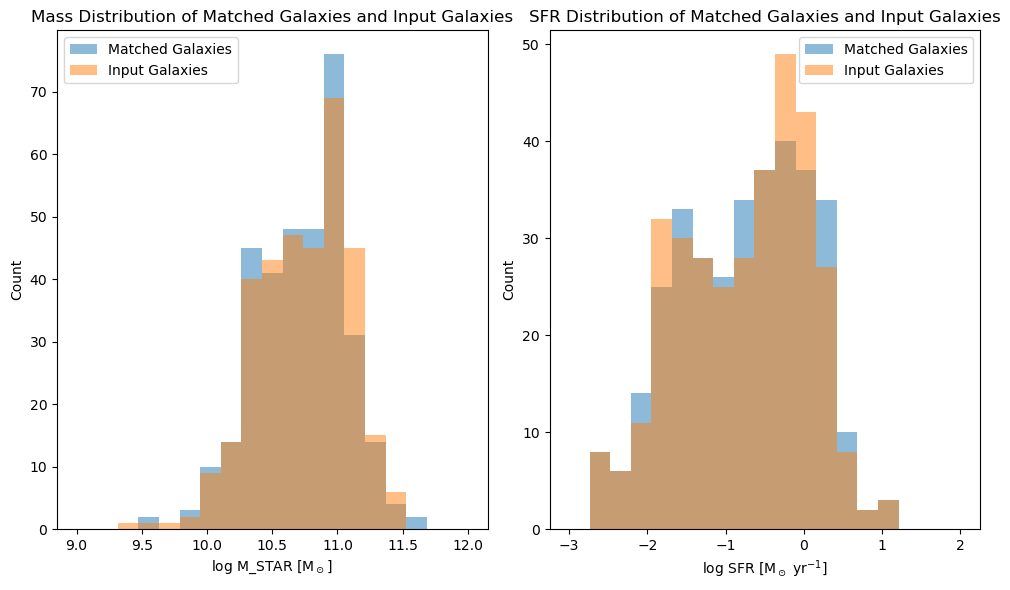

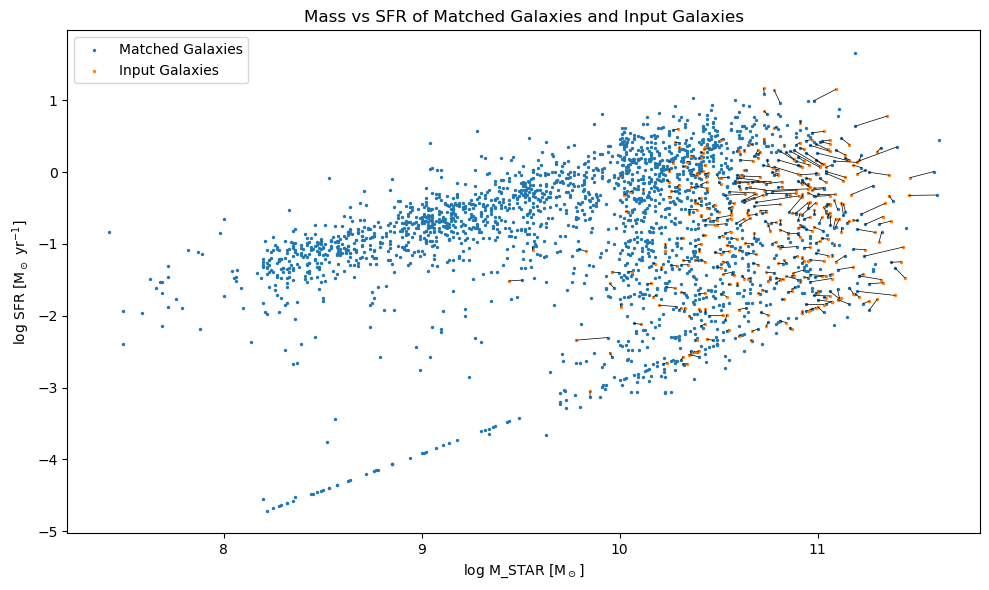

In [75]:
refresh_module()

valid_AGN_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (6, 7, 8, 9, 10))]

valid_HII_Composite_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (-1, 0, 1, 2))]

matched_AGN_HII_Composite = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_AGN_CATIDs, valid_HII_Composite_CATIDs, distribution_plots=True, scatter_plot=True)
matched_AGN_HII_Composite.rename_column('Input_CATID', 'AGN_CATID')
matched_AGN_HII_Composite.rename_column('Matched_CATID', 'HII_Composite_CATID')

matched_AGN_CATIDs = matched_AGN_HII_Composite['AGN_CATID']
matched_HII_Composite_CATIDs = matched_AGN_HII_Composite['HII_Composite_CATID']



### Median GASSIG Histogram

#### Linear scale

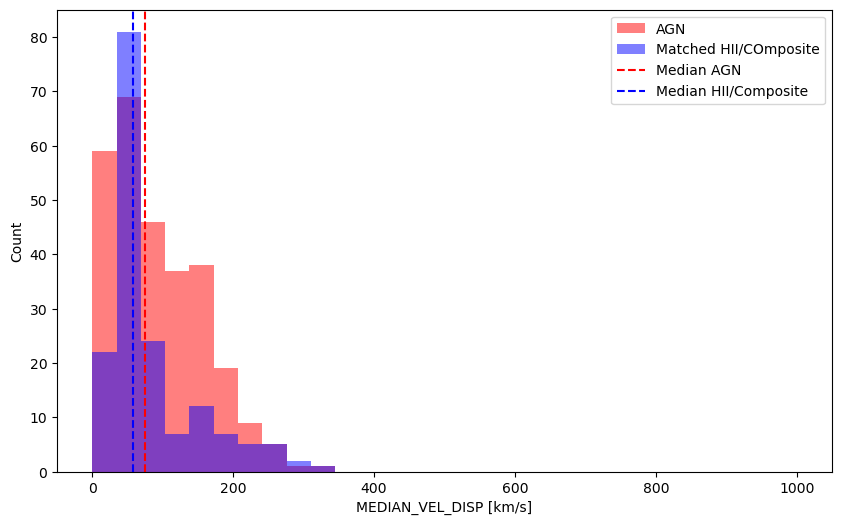

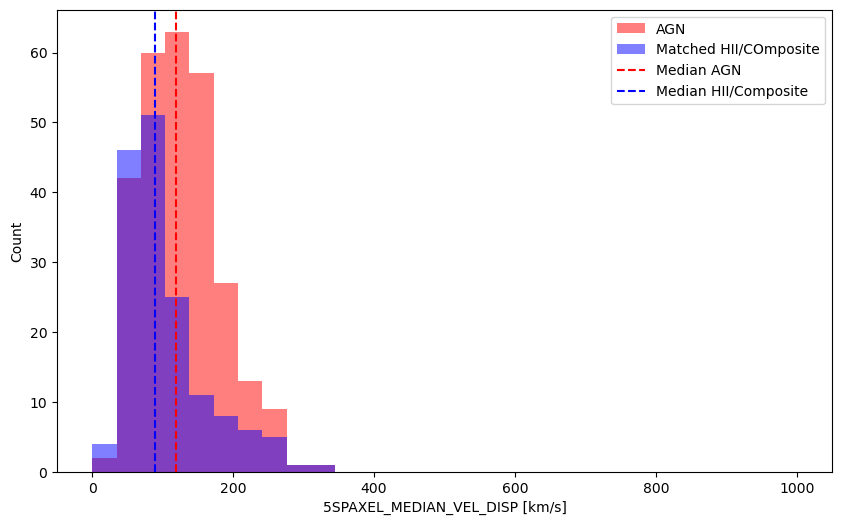

In [20]:
nbins = 30
bins = np.linspace(0, 1000, nbins)

plt.figure(figsize=(10,6))

plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_AGN_CATIDs)]['MEDIAN_VEL_DISP'], 
         color=AGN_colour, label = 'AGN', alpha = 0.5, bins=bins)

plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HII_Composite_CATIDs)]['MEDIAN_VEL_DISP'], 
         color=HII_Composite_colour, label = 'Matched HII/COmposite', alpha = 0.5, bins=bins)

plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_AGN_CATIDs)]['MEDIAN_VEL_DISP']), color=AGN_colour, linestyle='--', label='Median AGN')
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HII_Composite_CATIDs)]['MEDIAN_VEL_DISP']), color=HII_Composite_colour, linestyle='--', label='Median HII/Composite')

plt.ylabel('Count')
plt.xlabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()


plt.figure(figsize=(10,6))

plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_AGN_CATIDs)]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=AGN_colour, label = 'AGN', alpha = 0.5, bins=bins)

plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HII_Composite_CATIDs)]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=HII_Composite_colour, label = 'Matched HII/COmposite', alpha = 0.5, bins=bins)
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_AGN_CATIDs)]['5SPAXEL_MEDIAN_VEL_DISP']), color=AGN_colour, linestyle='--', label='Median AGN')
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HII_Composite_CATIDs)]['5SPAXEL_MEDIAN_VEL_DISP']), color=HII_Composite_colour, linestyle='--', label='Median HII/Composite')

plt.ylabel('Count')
plt.xlabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()

#### Log scale

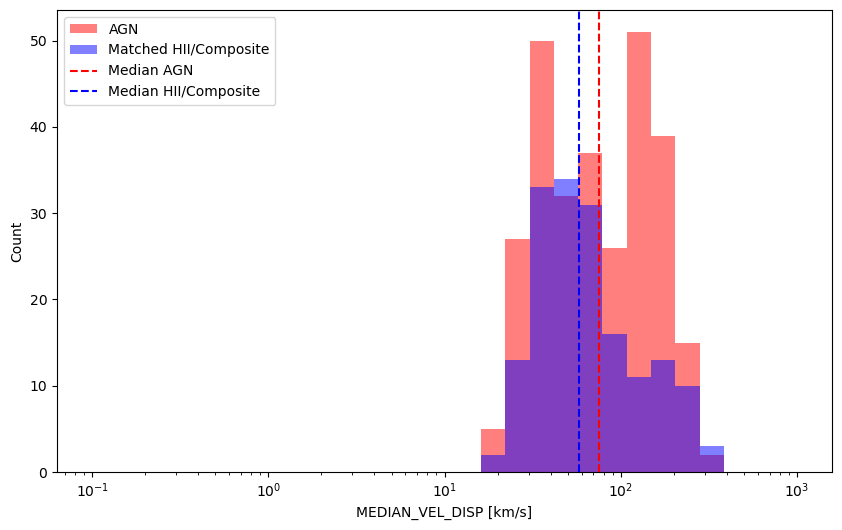

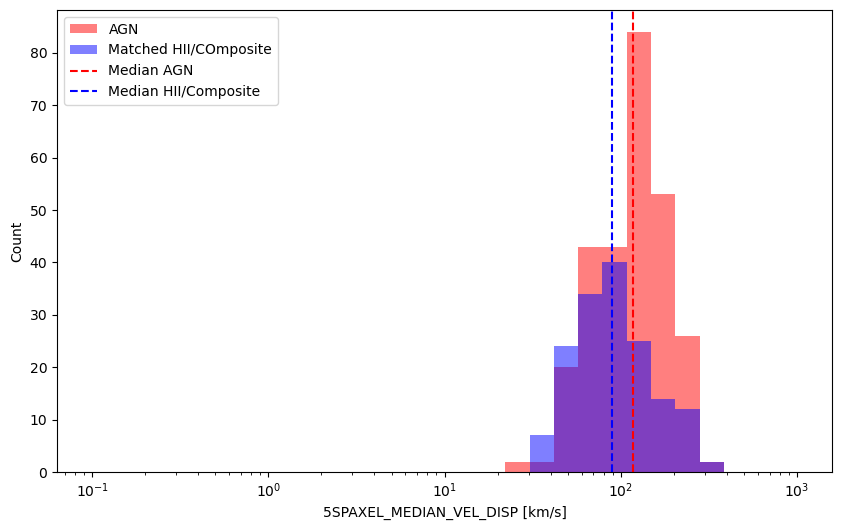

In [21]:
nbins = 30
bins = np.logspace(-1, 3, nbins)

plt.figure(figsize=(10,6))

plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_AGN_CATIDs)]['MEDIAN_VEL_DISP'], 
         color=AGN_colour, label = 'AGN', alpha = 0.5, bins=bins)

plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HII_Composite_CATIDs)]['MEDIAN_VEL_DISP'], 
         color=HII_Composite_colour, label = 'Matched HII/Composite', alpha = 0.5, bins=bins)
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_AGN_CATIDs)]['MEDIAN_VEL_DISP']), color=AGN_colour, linestyle='--', label='Median AGN')
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HII_Composite_CATIDs)]['MEDIAN_VEL_DISP']), color=HII_Composite_colour, linestyle='--', label='Median HII/Composite')

plt.ylabel('Count')
plt.xlabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.xscale('log')

nbins = 30
bins = np.logspace(-1, 3, nbins)

plt.figure(figsize=(10,6))

plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_AGN_CATIDs)]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=AGN_colour, label = 'AGN', alpha = 0.5, bins=bins)

plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HII_Composite_CATIDs)]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=HII_Composite_colour, label = 'Matched HII/COmposite', alpha = 0.5, bins=bins)

plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_AGN_CATIDs)]['5SPAXEL_MEDIAN_VEL_DISP']), color=AGN_colour, linestyle='--', label='Median AGN')
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HII_Composite_CATIDs)]['5SPAXEL_MEDIAN_VEL_DISP']), color=HII_Composite_colour, linestyle='--', label='Median HII/Composite')

plt.ylabel('Count')
plt.xlabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.xscale('log')

### Median GASSIG v M_STAR

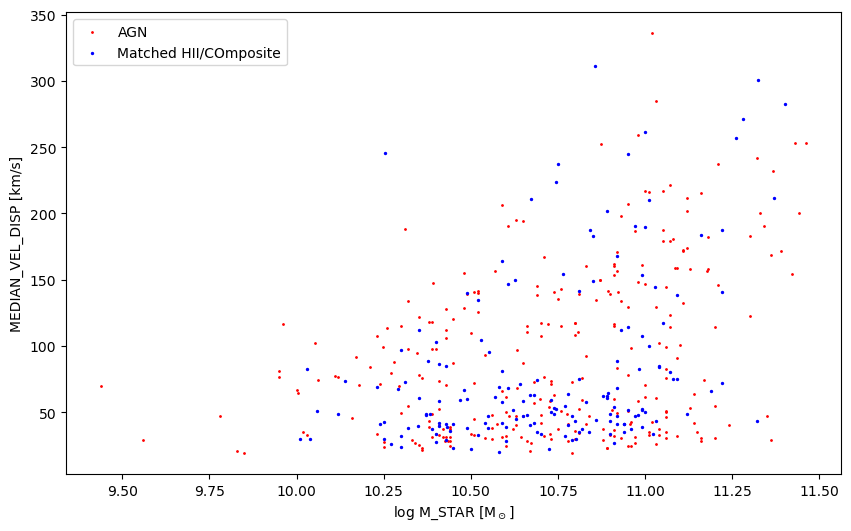

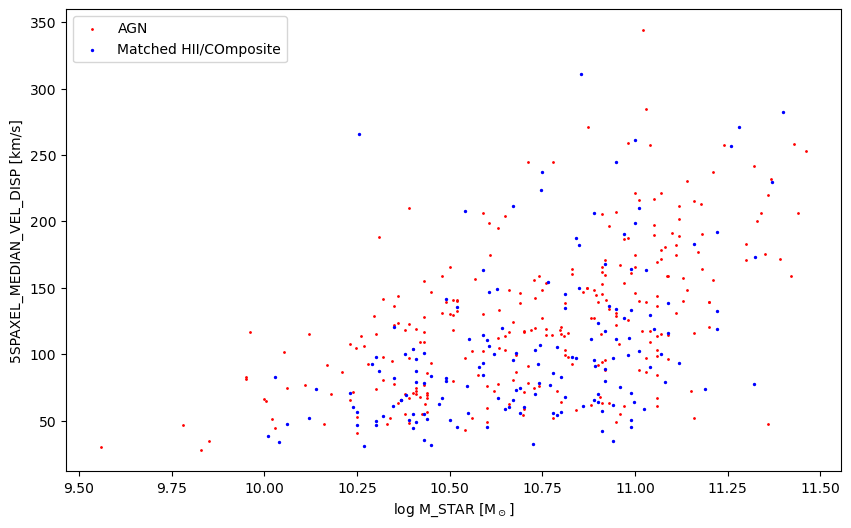

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_AGN_CATIDs)]['M_STAR'], joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_AGN_CATIDs)]['MEDIAN_VEL_DISP'], 
         color=AGN_colour, label = 'AGN', s =1)


plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HII_Composite_CATIDs)]['M_STAR'], joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HII_Composite_CATIDs)]['MEDIAN_VEL_DISP'], 
         color=HII_Composite_colour, label = 'Matched HII/COmposite', s =2)

plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_AGN_CATIDs)]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_AGN_CATIDs)]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=AGN_colour, label = 'AGN', s =1)
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HII_Composite_CATIDs)]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HII_Composite_CATIDs)]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=HII_Composite_colour, label = 'Matched HII/COmposite', s =2)
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

## Radio, non-Radio AGN matched

### M_STAR v SFR plot Radio, non-Radio, AGN

Number of valid HERGs: 43
Number of valid non-radio AGN: 295


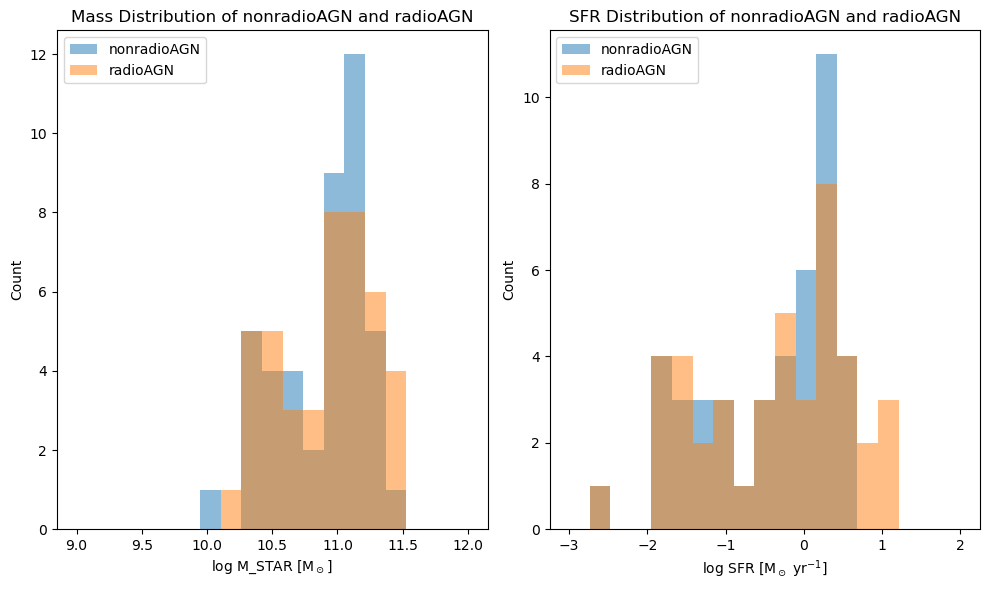

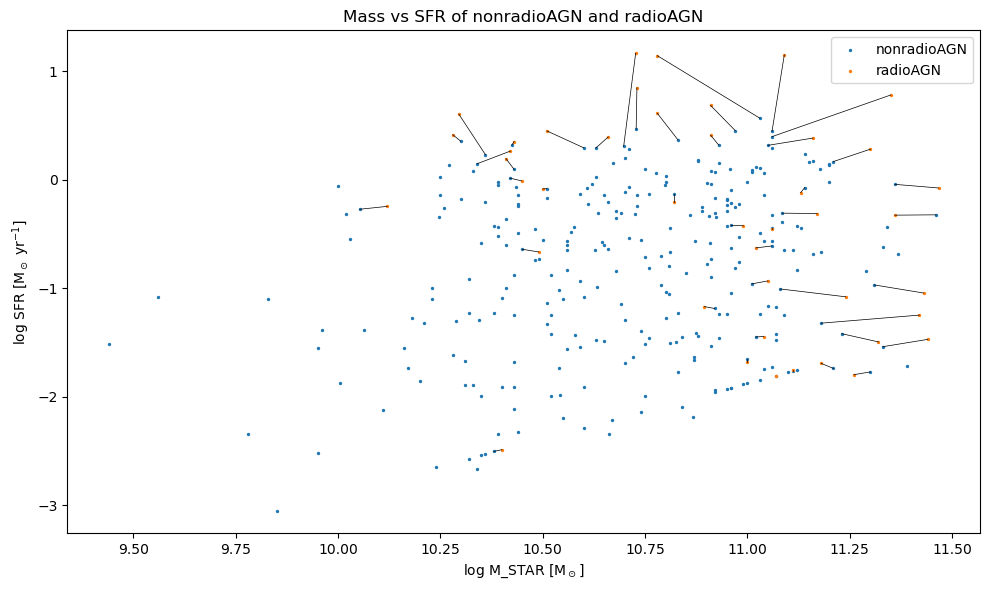

In [42]:
refresh_module()

valid_radioAGN_CATIDs = valid_Summary_table_hdu['CATID'][valid_AGN_mask& valid_radiosource_mask]
valid_nonradioAGN_CATIDs = valid_Summary_table_hdu['CATID'][valid_AGN_mask & ~valid_radiosource_mask]

print(f"Number of valid HERGs: {len(valid_radioAGN_CATIDs)}")
print(f"Number of valid non-radio AGN: {len(valid_nonradioAGN_CATIDs)}")

matched_radioAGN_to_nonradioAGN = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_radioAGN_CATIDs, valid_nonradioAGN_CATIDs, distribution_plots=True, labels=('nonradioAGN', 'radioAGN'), scatter_plot=True)
matched_radioAGN_to_nonradioAGN.rename_columns(['Input_CATID', 'Matched_CATID'], ['Radio_AGN_CATID', 'Non_Radio_AGN_CATID'])

### Median GASSIG Histograms

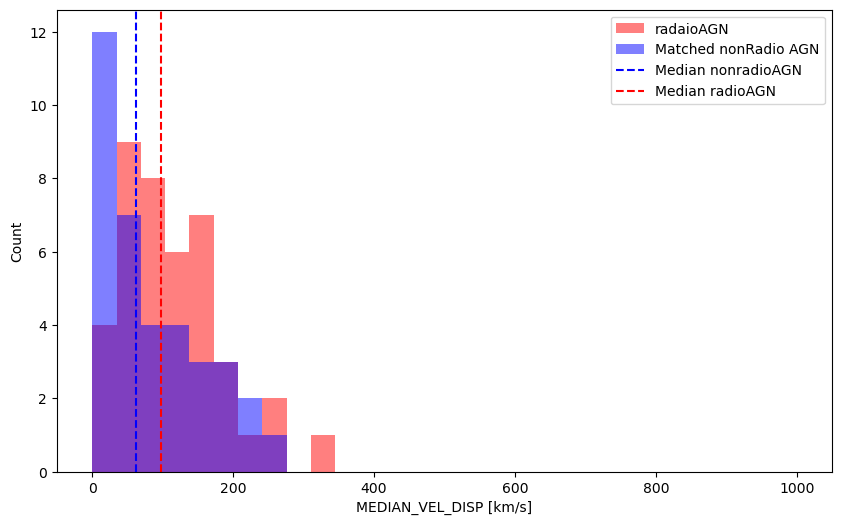

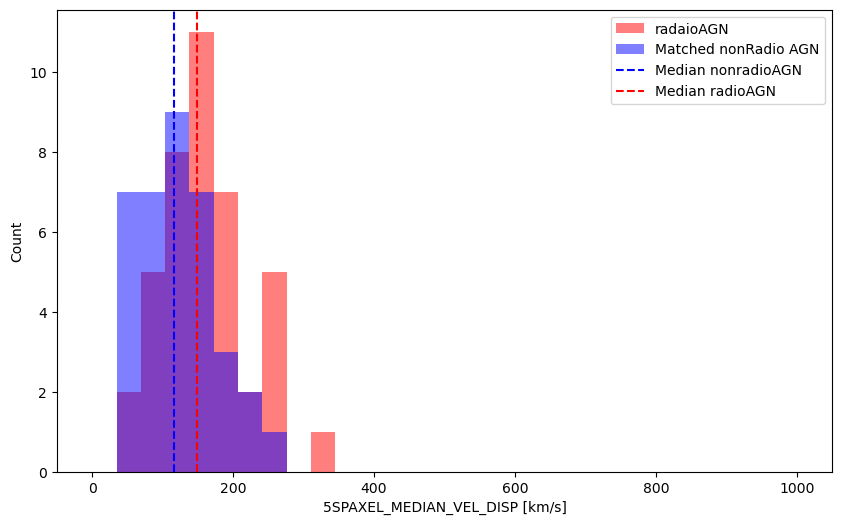

In [44]:
nbins = 30
bins = np.linspace(0, 1000, nbins)

plt.figure(figsize=(10,6))
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_nonradioAGN['Radio_AGN_CATID'])]['MEDIAN_VEL_DISP'], 
         color=radioAGN_colour, label = 'radioAGN', alpha = 0.5, bins=bins)
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_nonradioAGN['Non_Radio_AGN_CATID'])]['MEDIAN_VEL_DISP'], 
         color=nonradioAGN_colour, label = 'Matched nonRadio AGN', alpha = 0.5, bins=bins)

plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_nonradioAGN['Non_Radio_AGN_CATID'])]['MEDIAN_VEL_DISP']), color=nonradioAGN_colour, linestyle='--', label='Median nonradioAGN')
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_nonradioAGN['Radio_AGN_CATID'])]['MEDIAN_VEL_DISP']), color=radioAGN_colour, linestyle='--', label='Median radioAGN')
plt.ylabel('Count')
plt.xlabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_nonradioAGN['Radio_AGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=radioAGN_colour, label = 'radioAGN', alpha = 0.5, bins=bins)
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_nonradioAGN['Non_Radio_AGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=nonradioAGN_colour, label = 'Matched nonRadio AGN', alpha = 0.5, bins=bins)

plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_nonradioAGN['Non_Radio_AGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP']), color=nonradioAGN_colour, linestyle='--', label='Median nonradioAGN')
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_nonradioAGN['Radio_AGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP']), color=radioAGN_colour, linestyle='--', label='Median radioAGN')
plt.ylabel('Count')
plt.xlabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

### Median GASSIG v M_STAR

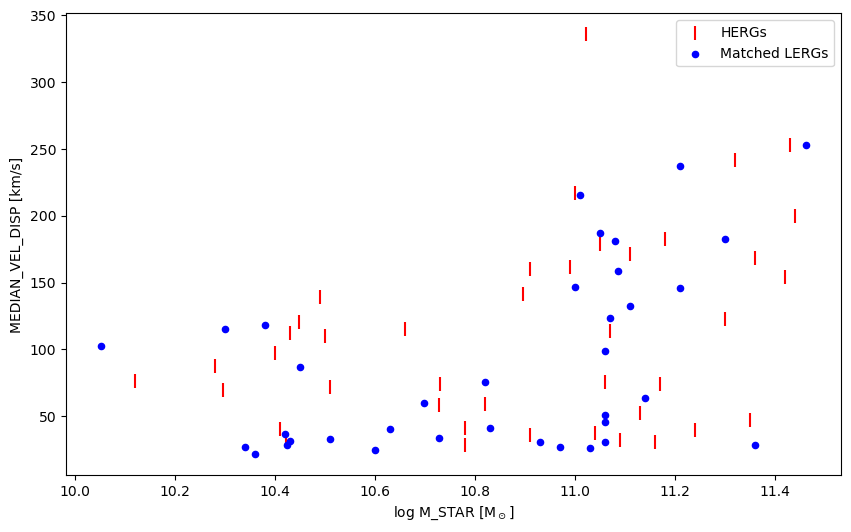

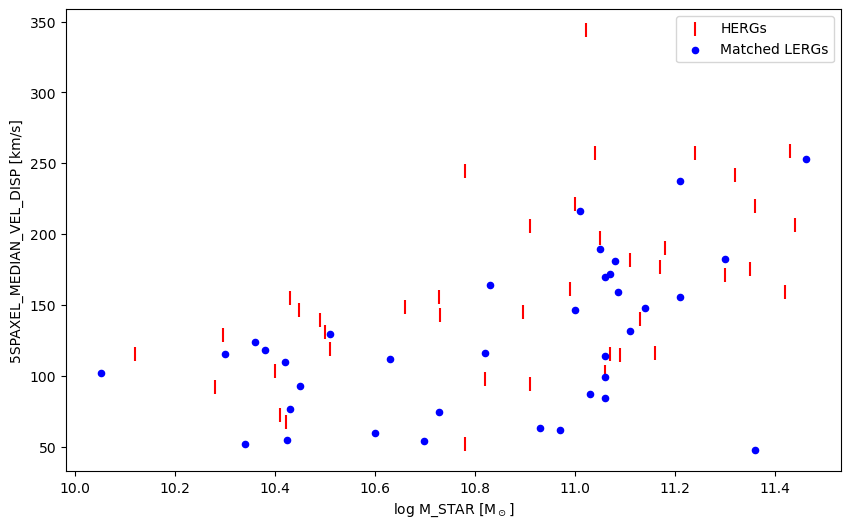

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_nonradioAGN['Radio_AGN_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_nonradioAGN['Radio_AGN_CATID'])]['MEDIAN_VEL_DISP'], 
         color=radioAGN_colour, marker= radiosource_marker, label = 'HERGs', s =100)
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_nonradioAGN['Non_Radio_AGN_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_nonradioAGN['Non_Radio_AGN_CATID'])]['MEDIAN_VEL_DISP'],  
            color=nonradioAGN_colour, marker= nosource_marker, label = 'Matched LERGs', s =20)
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_nonradioAGN['Radio_AGN_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_nonradioAGN['Radio_AGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=radioAGN_colour, marker= radiosource_marker, label = 'HERGs', s =100)
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_nonradioAGN['Non_Radio_AGN_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_nonradioAGN['Non_Radio_AGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
            color=nonradioAGN_colour, marker= nosource_marker, label = 'Matched LERGs', s =20)
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

## Radio AGN/non-AGN matched

Number of valid radio AGN: 43
Number of valid LERGs: 147


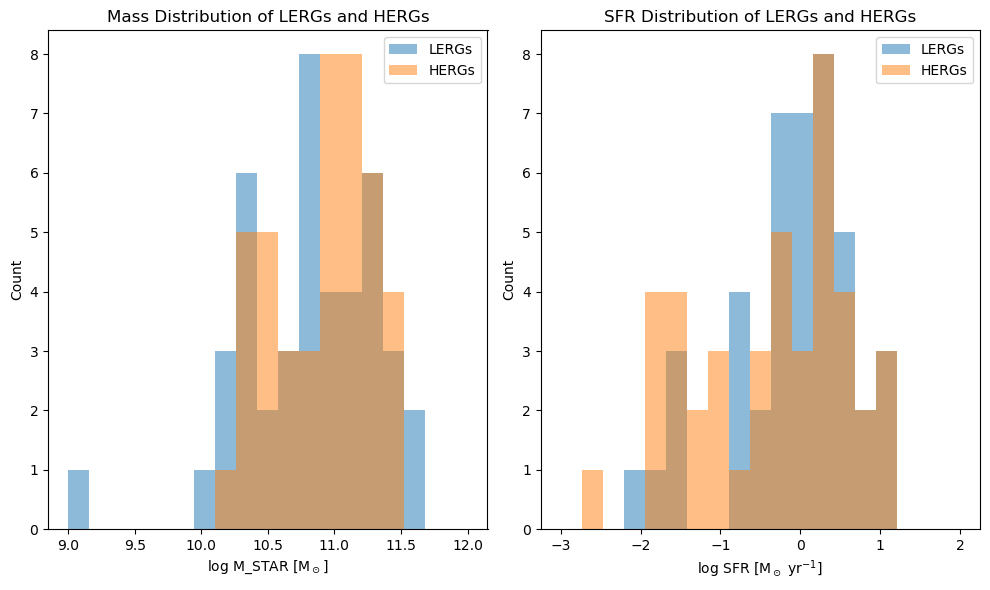

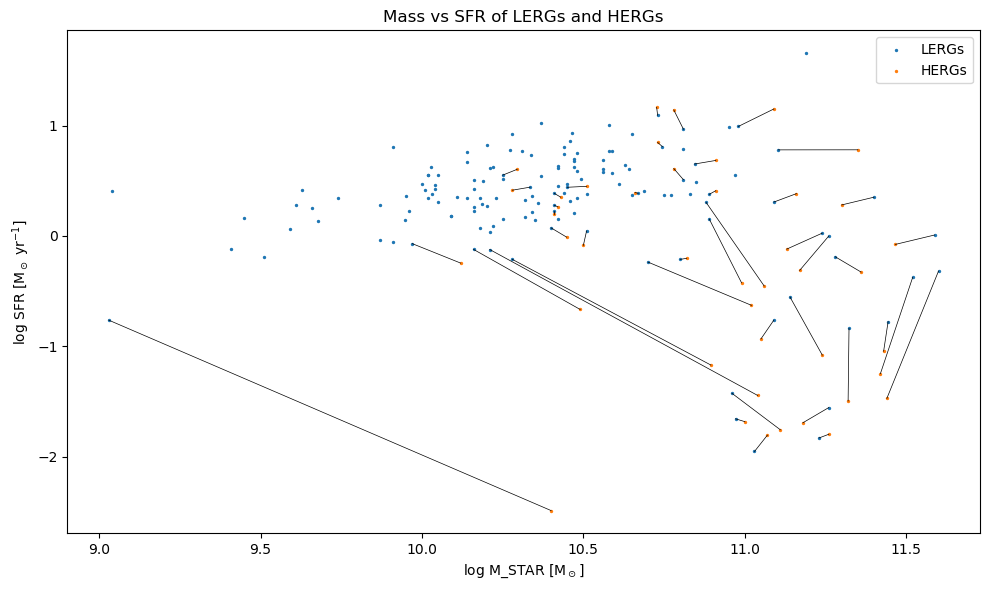

In [26]:
valid_radioAGN_CATIDs = valid_Summary_table_hdu['CATID'][valid_AGN_mask & valid_radiosource_mask]
valid_radioNonAGN_CATIDs = valid_Summary_table_hdu['CATID'][~valid_AGN_mask & valid_radiosource_mask]

print(f"Number of valid radio AGN: {len(valid_radioAGN_CATIDs)}")
print(f"Number of valid LERGs: {len(valid_radioNonAGN_CATIDs)}")

matched_radioAGN_to_radioNonAGN = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_radioAGN_CATIDs, valid_radioNonAGN_CATIDs, distribution_plots=True, labels=('LERGs', 'HERGs'), scatter_plot=True)
matched_radioAGN_to_radioNonAGN.rename_columns(['Input_CATID', 'Matched_CATID'], ['Radio_AGN_CATID', 'Radio_NonAGN_CATID'])


### Median GASSIG Histograms

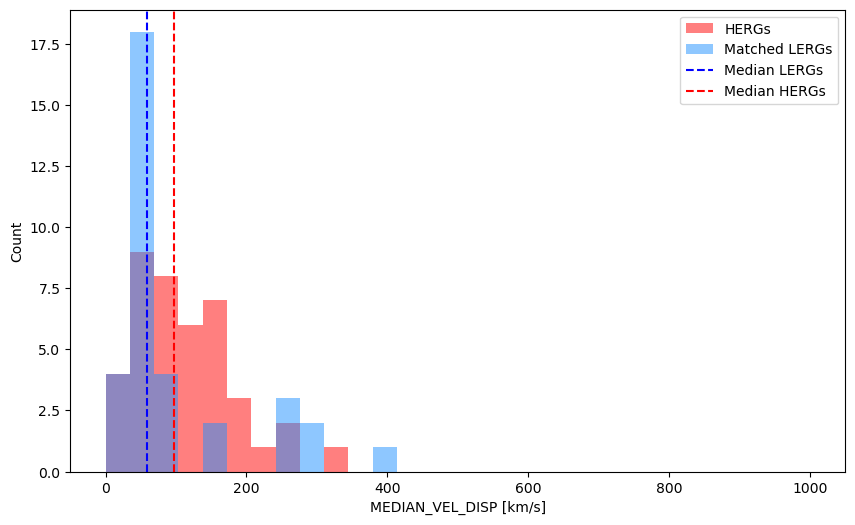

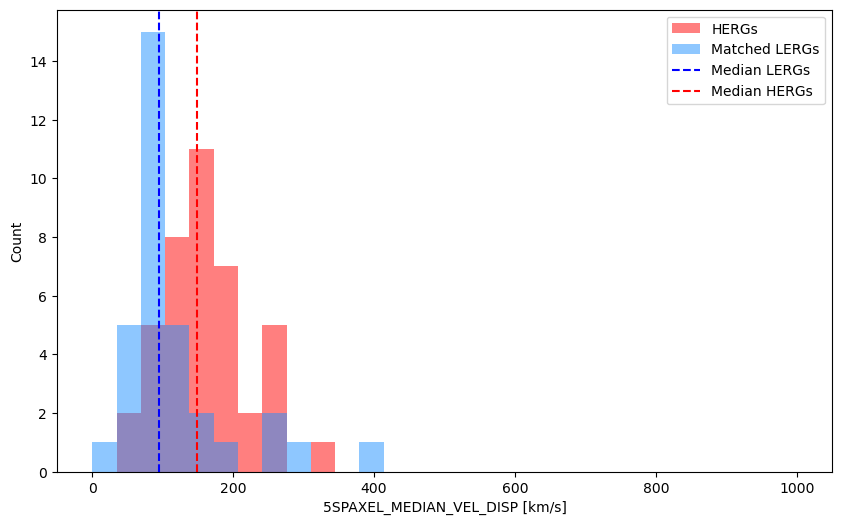

In [27]:
nbins = 30
bins = np.linspace(0, 1000, nbins)
plt.figure(figsize=(10,6))
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['MEDIAN_VEL_DISP'], 
         color=radioAGN_colour, label = 'HERGs', alpha = 0.5, bins=bins)
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['MEDIAN_VEL_DISP'], 
         color=radioNonAGN_colour, label = 'Matched LERGs', alpha = 0.5, bins=bins)
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['MEDIAN_VEL_DISP']), color=nonradioAGN_colour, linestyle='--', label='Median LERGs')
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['MEDIAN_VEL_DISP']), color=radioAGN_colour, linestyle='--', label='Median HERGs')
plt.ylabel('Count')
plt.xlabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=radioAGN_colour, label = 'HERGs', alpha = 0.5, bins=bins)
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=radioNonAGN_colour, label = 'Matched LERGs', alpha = 0.5, bins=bins)
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP']), color=nonradioAGN_colour, linestyle='--', label='Median LERGs')
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP']), color=radioAGN_colour, linestyle='--', label='Median HERGs')
plt.ylabel('Count')
plt.xlabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

### Median GASSIG v M_STAR

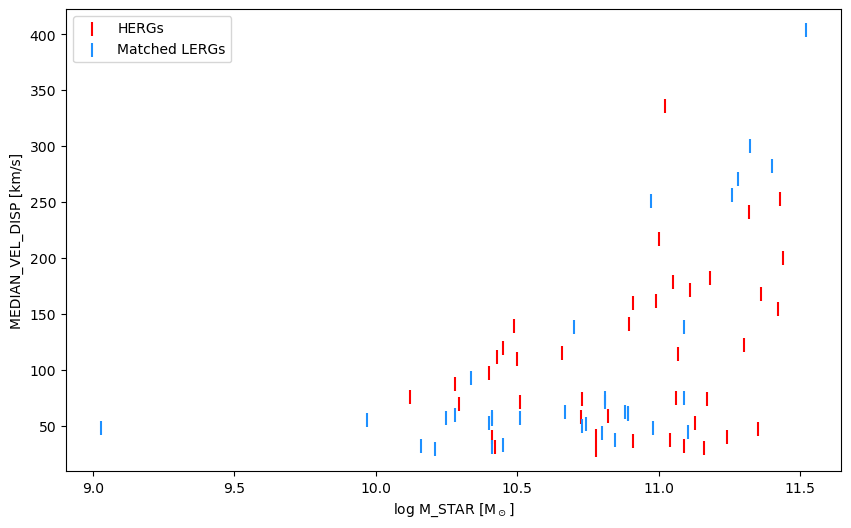

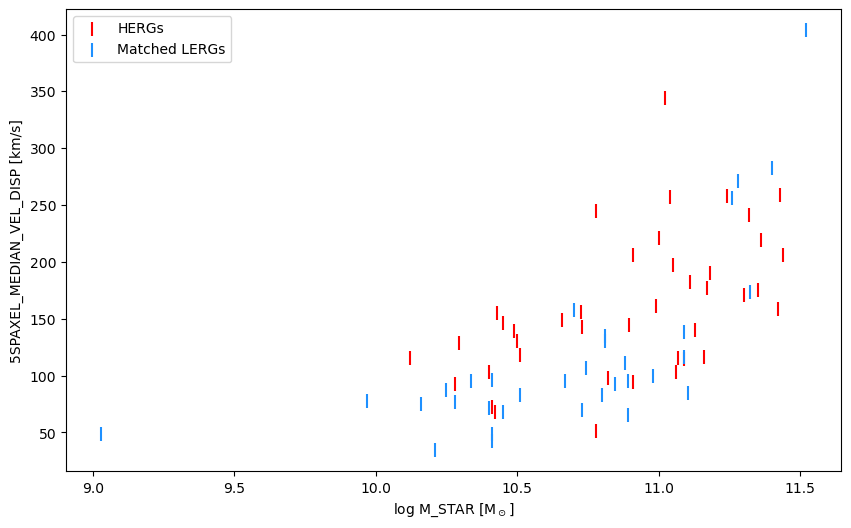

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['MEDIAN_VEL_DISP'], 
         color=radioAGN_colour, marker= radiosource_marker, label = 'HERGs', s =100)
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['MEDIAN_VEL_DISP'], 
            color=radioNonAGN_colour, marker= radiosource_marker, label = 'Matched LERGs', s =100)
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=radioAGN_colour, marker= radiosource_marker, label = 'HERGs', s =100)
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
            color=radioNonAGN_colour, marker= radiosource_marker, label = 'Matched LERGs', s =100)
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

### L_radio v M_STAR

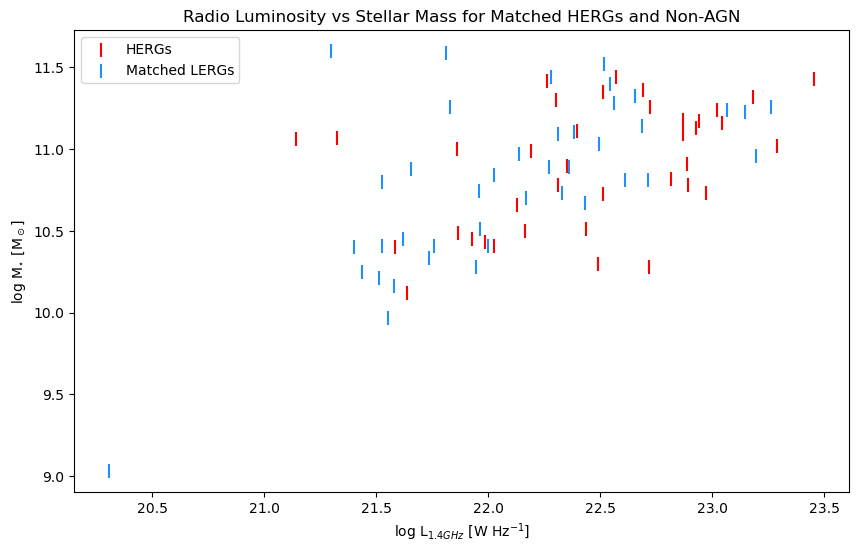

In [29]:
refresh_module()
plt.figure(figsize=(10, 6))
matched_radioAGN_mask = np.isin(valid_Summary_table_hdu['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])
matched_radioNonAGN_mask = np.isin(valid_Summary_table_hdu['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])

radioAGN_L_radio = all_fctns.get_radio_luminosity(valid_Summary_table_hdu, matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])
radioNonAGN_L_radio = all_fctns.get_radio_luminosity(valid_Summary_table_hdu, matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])
plt.scatter(np.log10(radioAGN_L_radio.value), valid_Summary_table_hdu['M_STAR'][matched_radioAGN_mask],
            color=radioAGN_colour, marker=radiosource_marker, label='HERGs', s=100)
plt.scatter(np.log10(radioNonAGN_L_radio.value), valid_Summary_table_hdu['M_STAR'][matched_radioNonAGN_mask],
            color=radioNonAGN_colour, marker=radiosource_marker, label='Matched LERGs', s=100)
plt.xlabel('log L$_{1.4GHz}$ [W Hz$^{-1}$]')
plt.ylabel('log M$_{\\star}$ [M$_\\odot$]')
plt.legend()
plt.title('Radio Luminosity vs Stellar Mass for Matched HERGs and Non-AGN')
plt.show()


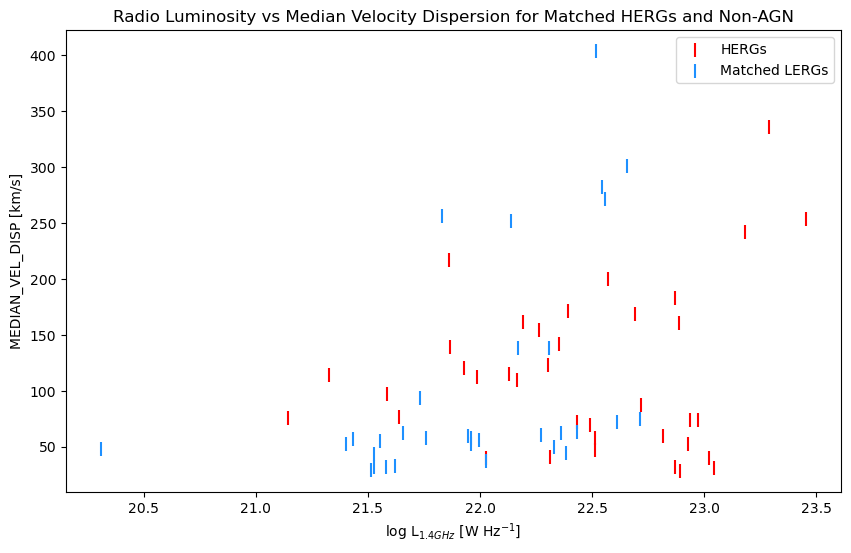

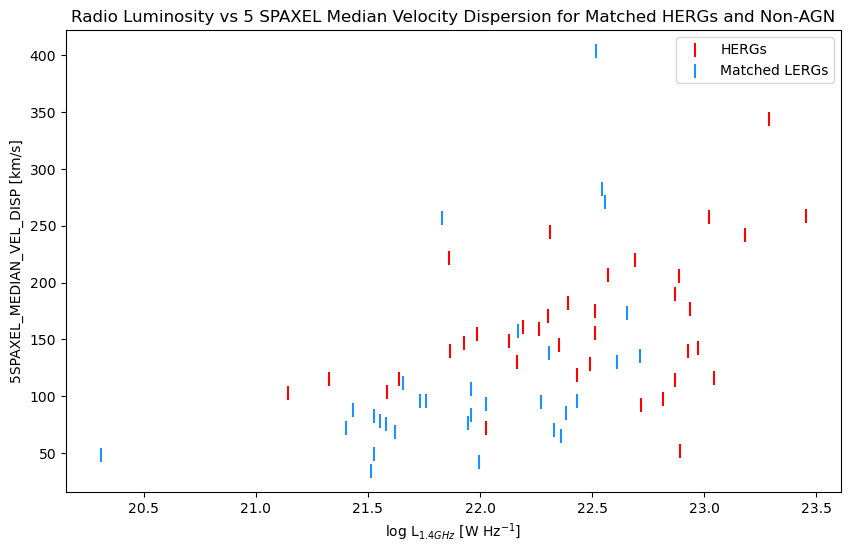

In [30]:
refresh_module()
plt.figure(figsize=(10, 6))
matched_radioAGN_mask = np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])
matched_radioNonAGN_mask = np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])

radioAGN_L_radio = all_fctns.get_radio_luminosity(joined_gassig_summary_table, matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])
radioNonAGN_L_radio = all_fctns.get_radio_luminosity(joined_gassig_summary_table, matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])

plt.scatter(np.log10(radioAGN_L_radio.value), joined_gassig_summary_table['MEDIAN_VEL_DISP'][matched_radioAGN_mask],
            color=radioAGN_colour, marker=radiosource_marker, label='HERGs', s=100)
plt.scatter(np.log10(radioNonAGN_L_radio.value), joined_gassig_summary_table['MEDIAN_VEL_DISP'][matched_radioNonAGN_mask],
            color=radioNonAGN_colour, marker=radiosource_marker, label='Matched LERGs', s=100)
plt.xlabel('log L$_{1.4GHz}$ [W Hz$^{-1}$]')
plt.ylabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.title('Radio Luminosity vs Median Velocity Dispersion for Matched HERGs and Non-AGN')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(np.log10(radioAGN_L_radio.value), joined_gassig_summary_table['5SPAXEL_MEDIAN_VEL_DISP'][matched_radioAGN_mask],
            color=radioAGN_colour, marker=radiosource_marker, label='HERGs', s=100)
plt.scatter(np.log10(radioNonAGN_L_radio.value), joined_gassig_summary_table['5SPAXEL_MEDIAN_VEL_DISP'][matched_radioNonAGN_mask],
            color=radioNonAGN_colour, marker=radiosource_marker, label='Matched LERGs', s=100)
plt.xlabel('log L$_{1.4GHz}$ [W Hz$^{-1}$]')
plt.ylabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.title('Radio Luminosity vs 5 SPAXEL Median Velocity Dispersion for Matched HERGs and Non-AGN')
plt.show()


## HERGs v LERGS

Number of valid HERGs: 36
Number of valid LERGs: 149


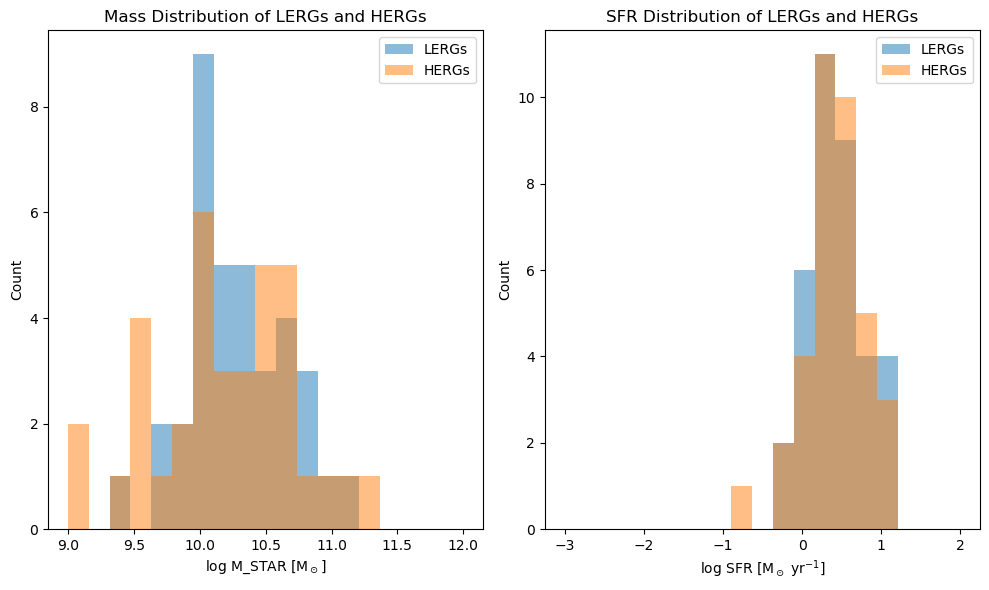

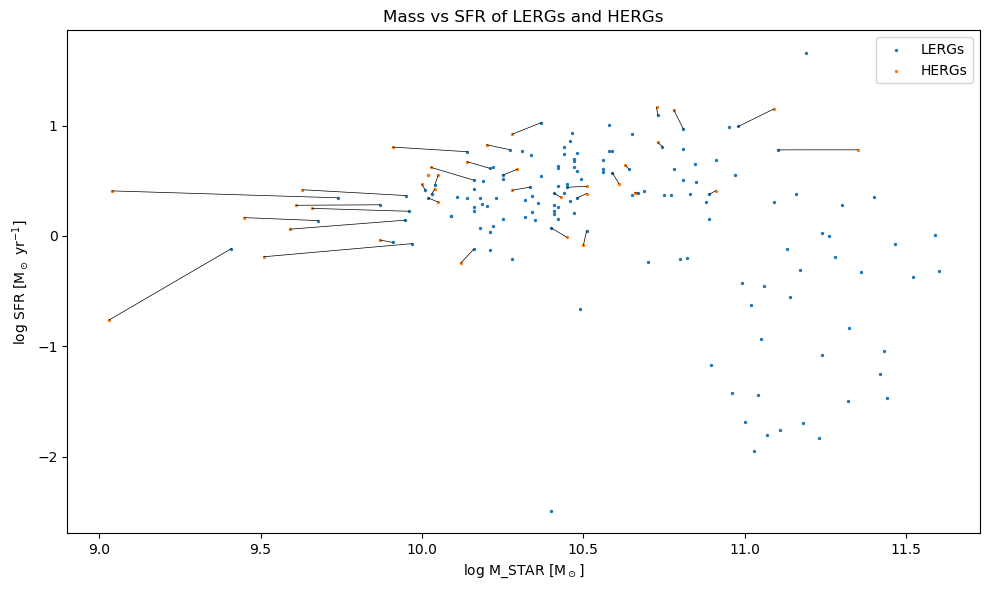

In [55]:
valid_HERG_CATIDs = valid_Summary_table_hdu['CATID'][valid_HERG_mask]
valid_LERG_CATIDs = valid_Summary_table_hdu['CATID'][valid_LERG_mask]

print(f"Number of valid HERGs: {len(valid_HERG_CATIDs)}")
print(f"Number of valid LERGs: {len(valid_LERG_CATIDs)}")

matched_HERG_to_LERG = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_HERG_CATIDs, valid_LERG_CATIDs, distribution_plots=True, labels=('LERGs', 'HERGs'), scatter_plot=True)
matched_HERG_to_LERG.rename_columns(['Input_CATID', 'Matched_CATID'], ['HERG_CATID', 'LERG_CATID'])


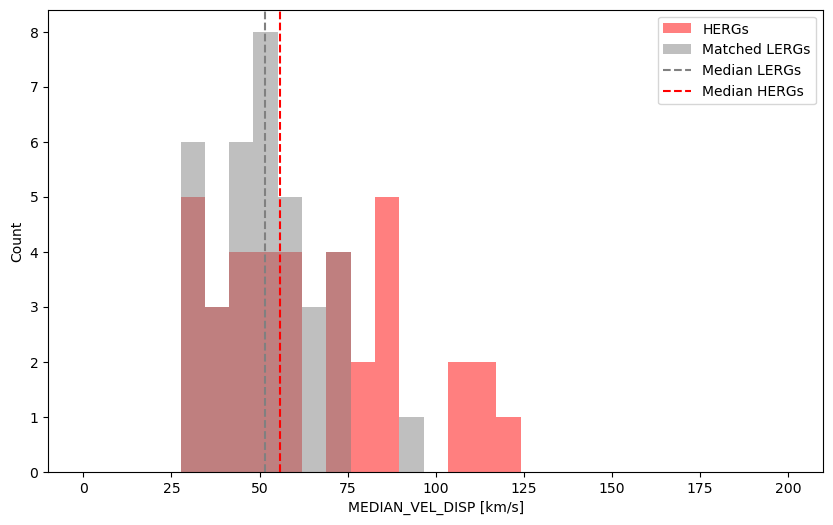

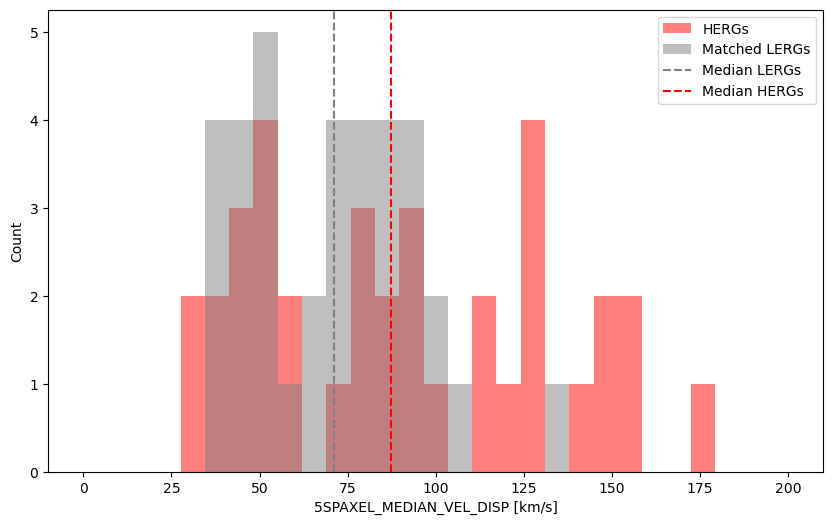

In [61]:
nbins = 30
bins = np.linspace(0, 200, nbins)
plt.figure(figsize=(10,6))
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HERG_to_LERG['HERG_CATID'])]['MEDIAN_VEL_DISP'], 
         color=HERG_colour, label = 'HERGs', alpha = 0.5, bins=bins)
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HERG_to_LERG['LERG_CATID'])]['MEDIAN_VEL_DISP'], 
         color=LERG_colour, label = 'Matched LERGs', alpha = 0.5, bins=bins)
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HERG_to_LERG['LERG_CATID'])]['MEDIAN_VEL_DISP']), color=LERG_colour, linestyle='--', label='Median LERGs')
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HERG_to_LERG['HERG_CATID'])]['MEDIAN_VEL_DISP']), color=HERG_colour, linestyle='--', label='Median HERGs')
plt.ylabel('Count')
plt.xlabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HERG_to_LERG['HERG_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=HERG_colour, label = 'HERGs', alpha = 0.5, bins=bins)
plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HERG_to_LERG['LERG_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=LERG_colour, label = 'Matched LERGs', alpha = 0.5, bins=bins)
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HERG_to_LERG['LERG_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP']), color=LERG_colour, linestyle='--', label='Median LERGs')
plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], matched_HERG_to_LERG['HERG_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP']), color=HERG_colour, linestyle='--', label='Median HERGs')
plt.ylabel('Count')
plt.xlabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

Median GASSIG v M_STAR

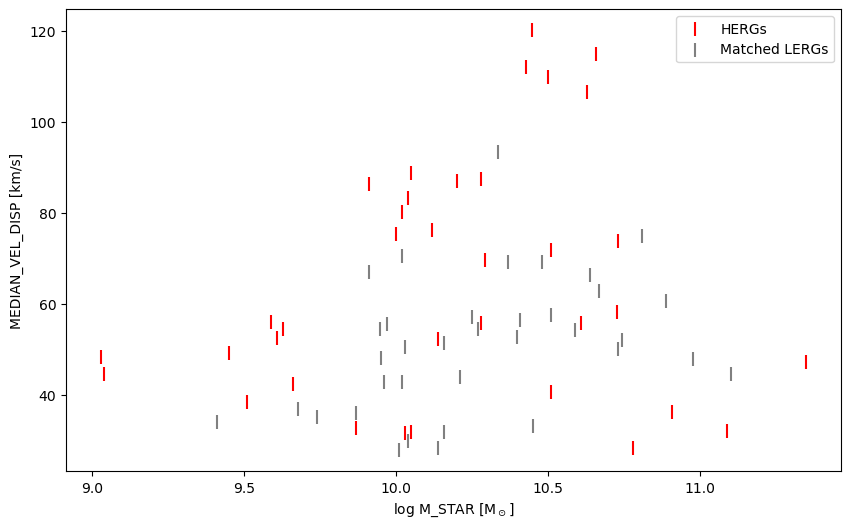

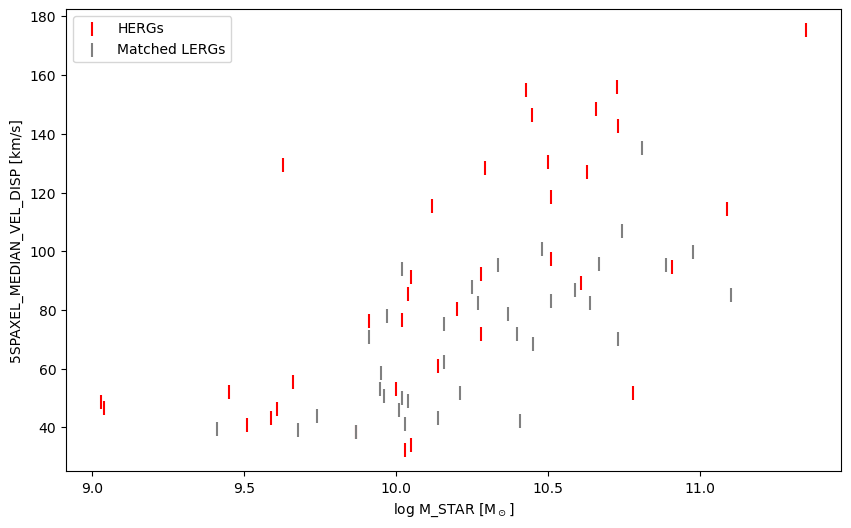

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HERG_to_LERG['HERG_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HERG_to_LERG['HERG_CATID'])]['MEDIAN_VEL_DISP'], 
         color=HERG_colour, marker= radiosource_marker, label = 'HERGs', s =100)
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HERG_to_LERG['LERG_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HERG_to_LERG['LERG_CATID'])]['MEDIAN_VEL_DISP'], 
            color=LERG_colour, marker= radiosource_marker, label = 'Matched LERGs', s =100)
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HERG_to_LERG['HERG_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HERG_to_LERG['HERG_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
         color=HERG_colour, marker= radiosource_marker, label = 'HERGs', s =100)
plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HERG_to_LERG['LERG_CATID'])]['M_STAR'], 
            joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_HERG_to_LERG['LERG_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
            color=LERG_colour, marker= radiosource_marker, label = 'Matched LERGs', s =100)
plt.xlabel('log M_STAR [M$_\\odot$]')
plt.ylabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.show()

### L_radio v M_STAR

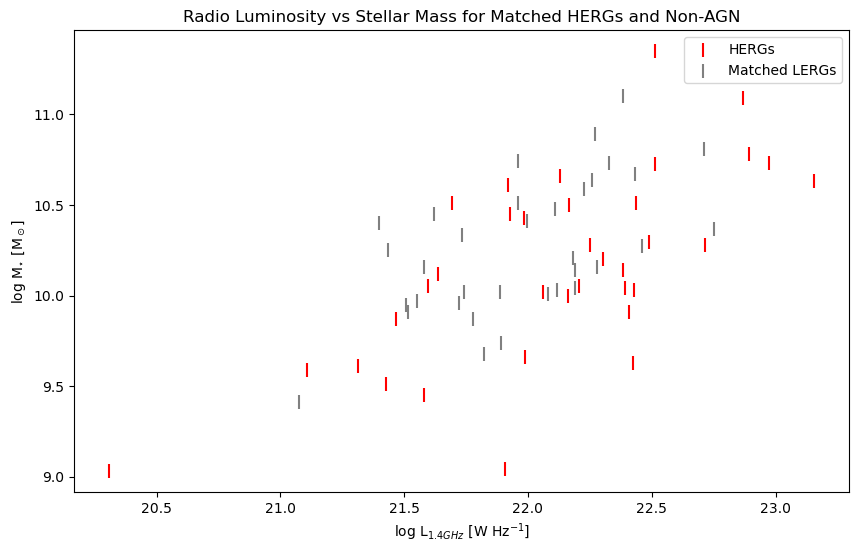

In [63]:
refresh_module()
plt.figure(figsize=(10, 6))
matched_HERG_mask = np.isin(valid_Summary_table_hdu['CATID'], matched_HERG_to_LERG['HERG_CATID'])
matched_LERG_mask = np.isin(valid_Summary_table_hdu['CATID'], matched_HERG_to_LERG['LERG_CATID'])

HERG_L_radio = all_fctns.get_radio_luminosity(valid_Summary_table_hdu, matched_HERG_to_LERG['HERG_CATID'])
LERG_L_radio = all_fctns.get_radio_luminosity(valid_Summary_table_hdu, matched_HERG_to_LERG['LERG_CATID'])
plt.scatter(np.log10(HERG_L_radio.value), valid_Summary_table_hdu['M_STAR'][matched_HERG_mask],
            color=HERG_colour, marker=radiosource_marker, label='HERGs', s=100)
plt.scatter(np.log10(LERG_L_radio.value), valid_Summary_table_hdu['M_STAR'][matched_LERG_mask],
            color=LERG_colour, marker=radiosource_marker, label='Matched LERGs', s=100)
plt.xlabel('log L$_{1.4GHz}$ [W Hz$^{-1}$]')
plt.ylabel('log M$_{\\star}$ [M$_\\odot$]')
plt.legend()
plt.title('Radio Luminosity vs Stellar Mass for Matched HERGs and Non-AGN')
plt.show()

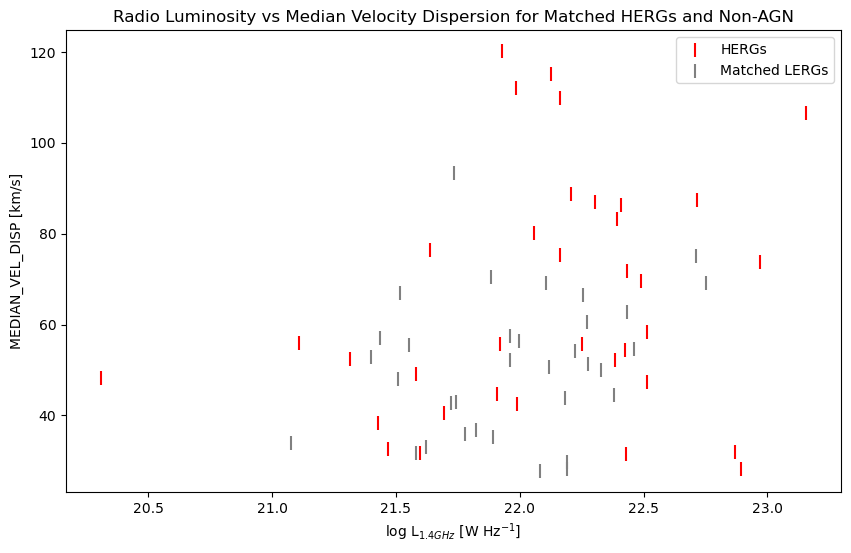

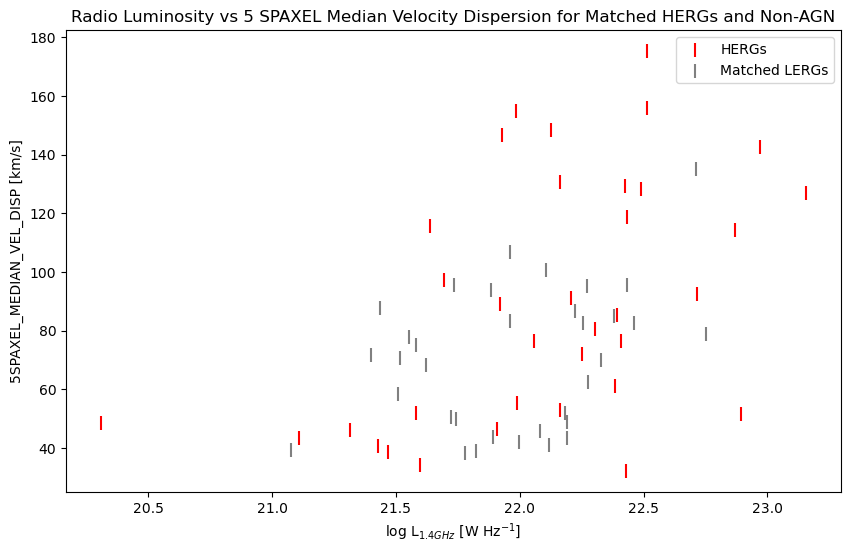

In [64]:
refresh_module()
plt.figure(figsize=(10, 6))
matched_HERG_mask = np.isin(joined_gassig_summary_table['CATID'], matched_HERG_to_LERG['HERG_CATID'])
matched_LERG_mask = np.isin(joined_gassig_summary_table['CATID'], matched_HERG_to_LERG['LERG_CATID'])

HERG_L_radio = all_fctns.get_radio_luminosity(joined_gassig_summary_table, matched_HERG_to_LERG['HERG_CATID'])
LERG_L_radio = all_fctns.get_radio_luminosity(joined_gassig_summary_table, matched_HERG_to_LERG['LERG_CATID'])

plt.scatter(np.log10(HERG_L_radio.value), joined_gassig_summary_table['MEDIAN_VEL_DISP'][matched_HERG_mask],
            color=HERG_colour, marker=radiosource_marker, label='HERGs', s=100)
plt.scatter(np.log10(LERG_L_radio.value), joined_gassig_summary_table['MEDIAN_VEL_DISP'][matched_LERG_mask],
            color=LERG_colour, marker=radiosource_marker, label='Matched LERGs', s=100)
plt.xlabel('log L$_{1.4GHz}$ [W Hz$^{-1}$]')
plt.ylabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.title('Radio Luminosity vs Median Velocity Dispersion for Matched HERGs and Non-AGN')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(np.log10(HERG_L_radio.value), joined_gassig_summary_table['5SPAXEL_MEDIAN_VEL_DISP'][matched_HERG_mask],
            color=HERG_colour, marker=radiosource_marker, label='HERGs', s=100)
plt.scatter(np.log10(LERG_L_radio.value), joined_gassig_summary_table['5SPAXEL_MEDIAN_VEL_DISP'][matched_LERG_mask],
            color=LERG_colour, marker=radiosource_marker, label='Matched LERGs', s=100)
plt.xlabel('log L$_{1.4GHz}$ [W Hz$^{-1}$]')
plt.ylabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.title('Radio Luminosity vs 5 SPAXEL Median Velocity Dispersion for Matched HERGs and Non-AGN')
plt.show()


## 4 Way Matched


In [47]:
refresh_module()
show_plots = False

valid_HERG_CATIDs = valid_Summary_table_hdu['CATID'][valid_HERG_mask]
valid_LERG_CATIDs = valid_Summary_table_hdu['CATID'][valid_LERG_mask]
valid_radioquiteAGN_CATIDS = valid_Summary_table_hdu['CATID'][valid_AGN_mask & ~valid_radiosource_mask]
valid_nonRadioNonAGN_CATIDS = valid_Summary_table_hdu['CATID'][~valid_AGN_mask & ~valid_radiosource_mask]


print(f"Number of valid HERGHs: {len(valid_radioAGN_CATIDs)}")
print(f"Number of valid LERGs: {len(valid_radioNonAGN_CATIDs)}")
print(f"Number of valid Radio-quiet AGN: {len(valid_radioquiteAGN_CATIDS)}")
print(f"Number of valid not radio or BPT AGN: {len(valid_nonRadioNonAGN_CATIDS)}")



matched_HERG_to_LERG = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_HERG_CATIDs, valid_LERG_CATIDs, distribution_plots=show_plots, labels=('LERGs', 'HERGs'), scatter_plot=show_plots)
matched_HERG_to_LERG.rename_columns(['Input_CATID', 'Matched_CATID'], ['Radio_AGN_CATID', 'Radio_NonAGN_CATID'])
matched_HERG_to_LERG.remove_column('min_diff')

matched_HERG_to_radioquiteAGN = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_HERG_CATIDs, valid_radioquiteAGN_CATIDS, distribution_plots=show_plots, labels=('Radio-quiet AGN', 'HERGs'), scatter_plot=show_plots)
matched_HERG_to_radioquiteAGN.rename_columns(['Input_CATID', 'Matched_CATID'], ['Radio_AGN_CATID', 'NonRadio_AGN_CATID'])
matched_HERG_to_radioquiteAGN.remove_column('min_diff')

matched_HERG_to_nonRadioNonAGN  = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_HERG_CATIDs, valid_nonRadioNonAGN_CATIDS, distribution_plots=show_plots, labels=('not radio or BPT AGN', 'HERGs'), scatter_plot=show_plots)
matched_HERG_to_nonRadioNonAGN.rename_columns(['Input_CATID', 'Matched_CATID'], ['Radio_AGN_CATID', 'NonRadio_NonAGN_CATID'])
matched_HERG_to_nonRadioNonAGN.remove_column('min_diff')
# combine into one table

matched_radioAGNsplit_table = join(matched_HERG_to_LERG, matched_HERG_to_radioquiteAGN, keys = 'Radio_AGN_CATID', join_type = 'left', table_names = ['1', '2'])
matched_radioAGNsplit_table = join(matched_radioAGNsplit_table, matched_HERG_to_nonRadioNonAGN, keys = 'Radio_AGN_CATID', join_type = 'left', table_names = ['6', '4'])


radiosource_AGN_CATID_dict ={ 'HERG': 'Radio_AGN_CATID',
                        'Radio-quiet AGN': 'NonRadio_AGN_CATID',
                        'LERG': 'Radio_NonAGN_CATID',
                        'Not AGN BPT & Radio-quiet': 'NonRadio_NonAGN_CATID'}

matched_radioAGNsplit_table


Number of valid HERGHs: 43
Number of valid LERGs: 147
Number of valid Radio-quiet AGN: 295
Number of valid not radio or BPT AGN: 2172


Radio_AGN_CATID,Radio_NonAGN_CATID,NonRadio_AGN_CATID,NonRadio_NonAGN_CATID
int64,int64,int64,int64
39145,9091700089,548914,209181
47493,238395,508568,62718
64553,371789,345820,545411
69740,9016800234,9008501058,227036
70114,514212,220330,55372
70403,386720,622228,15898
78425,574029,622596,288364
79335,298862,9016800276,9239900565
105738,594313,611220,298590


### Median GASSIG Histograms

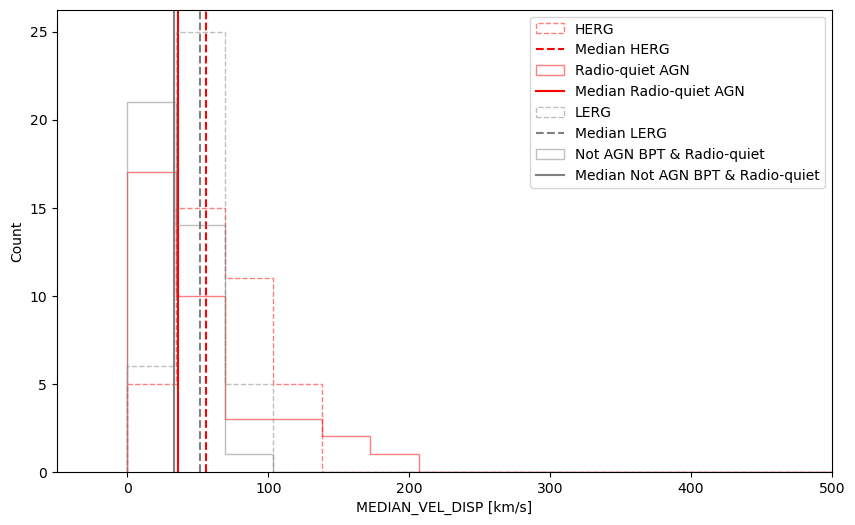

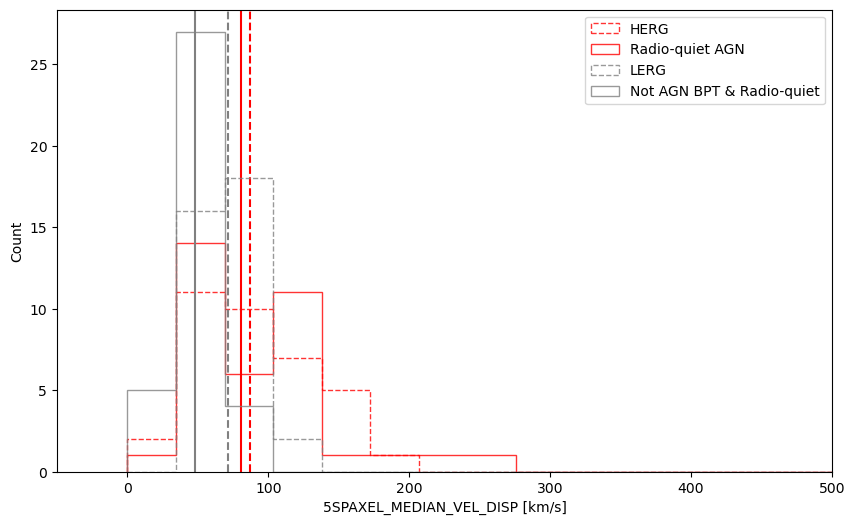

In [48]:
nbins = 30
bins = np.linspace(0, 1000, nbins)

gassig_statistic = 'MEDIAN_VEL_DISP'
alpha = 0.5
plt.figure(figsize=(10,6))

# check valid gassig_statistic for each CATID
reduced_matched_radioAGNsplit_table = matched_radioAGNsplit_table.copy()
valid_catids = gassig_statistics_table['CATID'][~np.isnan(gassig_statistics_table[gassig_statistic])]

mask = []
for row in matched_radioAGNsplit_table:
    row_array = np.array(row.as_void().tolist(), dtype=int)
    mask.append(np.all(np.isin(row_array, valid_catids)))

mask = np.array(mask)
reduced_matched_radioAGNsplit_table = reduced_matched_radioAGNsplit_table[mask]

for source_type, (source_mask, colour, marker, linestyle, point_size) in radiosource_AGN_dict.items():
    catid_col = radiosource_AGN_CATID_dict[source_type]
    plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table[catid_col])][gassig_statistic], 
         color=colour, label = source_type, alpha = alpha, bins=bins, histtype='step', linestyle=linestyle)
    
    plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table[catid_col])][gassig_statistic]), color=colour, linestyle=linestyle, label=f'Median {source_type}')

    
# plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['Radio_NonAGN_CATID'])][gassig_statistic], 
#          color=radioNonAGN_colour, label = 'LERGs', alpha = 0.5, bins=bins, histtype='step')
# plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_AGN_CATID'])][gassig_statistic], 
#          color=nonradioAGN_colour, label = 'Radio-quiet AGN', alpha = 0.5, bins=bins, histtype='step')
# plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_NonAGN_CATID'])][gassig_statistic], 
#          color=nonradioNonAGN_colour, label = 'Not Radio or BPT AGN', alpha = 0.5, bins=bins, histtype='step')



# plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['Radio_AGN_CATID'])][gassig_statistic]), color=radioAGN_colour, linestyle=radiosource_linestyle, label='Median HERGs')
# plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_AGN_CATID'])][gassig_statistic]), color=nonradioAGN_colour, linestyle='-', label='Median Radio-quiet AGN')
# plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_NonAGN_CATID'])][gassig_statistic]), color=nonradioNonAGN_colour, linestyle='-', label='Median Not Radio or BPT AGN')

plt.ylabel('Count')
plt.xlabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.xlim((-50,500))

plt.show()


gassig_statistic = '5SPAXEL_MEDIAN_VEL_DISP'

alpha = 0.8
plt.figure(figsize=(10,6))

# check valid gassig_statistic for each CATID
reduced_matched_radioAGNsplit_table = matched_radioAGNsplit_table.copy()
valid_catids = gassig_statistics_table['CATID'][~np.isnan(gassig_statistics_table[gassig_statistic])]

mask = []
for row in matched_radioAGNsplit_table:
    row_array = np.array(row.as_void().tolist(), dtype=int)
    mask.append(np.all(np.isin(row_array, valid_catids)))

mask = np.array(mask)
reduced_matched_radioAGNsplit_table = reduced_matched_radioAGNsplit_table[mask]

for source_type, (source_mask, colour, marker, linestyle, point_size) in radiosource_AGN_dict.items():
    catid_col = radiosource_AGN_CATID_dict[source_type]
    plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table[catid_col])][gassig_statistic], 
         color=colour, label = source_type, alpha = alpha, bins=bins, histtype='step', linestyle=linestyle)
    
    plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table[catid_col])][gassig_statistic]), color=colour, linestyle=linestyle)#, label=f'Median {source_type}')

    
# plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['Radio_NonAGN_CATID'])][gassig_statistic], 
#          color=radioNonAGN_colour, label = 'LERGs', alpha = 0.5, bins=bins, histtype='step')
# plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_AGN_CATID'])][gassig_statistic], 
#          color=nonradioAGN_colour, label = 'Radio-quiet AGN', alpha = 0.5, bins=bins, histtype='step')
# plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_NonAGN_CATID'])][gassig_statistic], 
#          color=nonradioNonAGN_colour, label = 'Not Radio or BPT AGN', alpha = 0.5, bins=bins, histtype='step')



# plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['Radio_AGN_CATID'])][gassig_statistic]), color=radioAGN_colour, linestyle=radiosource_linestyle, label='Median HERGs')
# plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_AGN_CATID'])][gassig_statistic]), color=nonradioAGN_colour, linestyle='-', label='Median Radio-quiet AGN')
# plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_NonAGN_CATID'])][gassig_statistic]), color=nonradioNonAGN_colour, linestyle='-', label='Median Not Radio or BPT AGN')

plt.ylabel('Count')
plt.xlabel('5SPAXEL_MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.xlim((-50,500))

plt.show()

### Median GASSIG v M_STAR

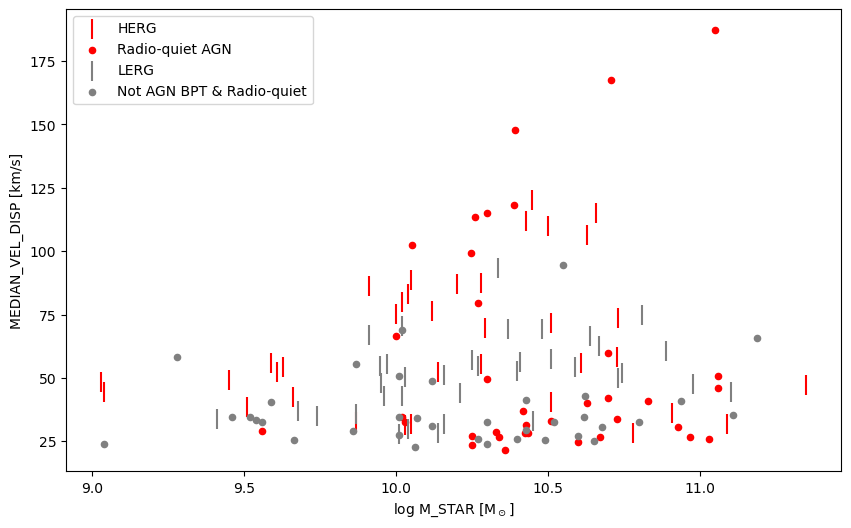

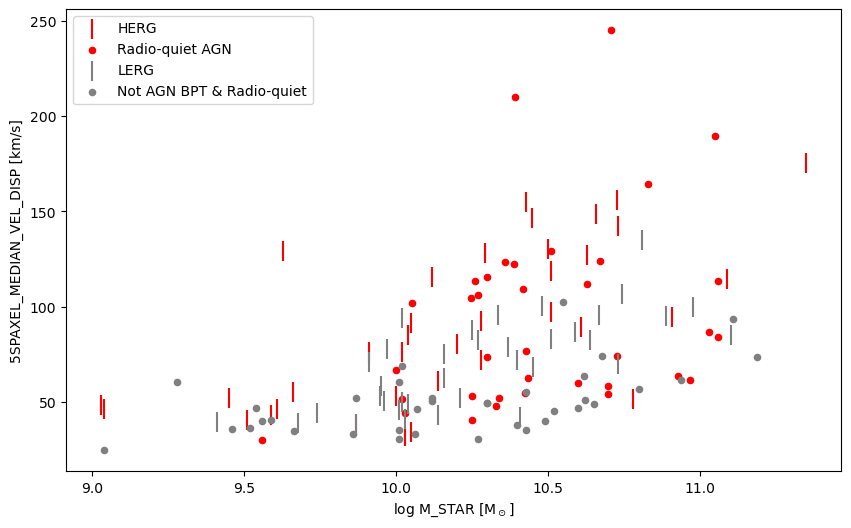

In [50]:
# plt.figure(figsize=(10, 6))
# plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['M_STAR'], 
#             joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['MEDIAN_VEL_DISP'], 
#          color=radioAGN_colour, marker= radiosource_marker, label = 'HERGs', s =100)
# plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['M_STAR'], 
#             joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['MEDIAN_VEL_DISP'], 
#             color=radioNonAGN_colour, marker= radiosource_marker, label = 'Matched LERGs', s =100)
# plt.xlabel('log M_STAR [M$_\\odot$]')
# plt.ylabel('MEDIAN_VEL_DISP [km/s]')
# plt.legend()
# plt.show()


gassig_statistic = 'MEDIAN_VEL_DISP'
for gassig_statistic in ('MEDIAN_VEL_DISP', '5SPAXEL_MEDIAN_VEL_DISP'):

    alpha = 0.5
    plt.figure(figsize=(10,6))

    # check valid gassig_statistic for each CATID
    reduced_matched_radioAGNsplit_table = matched_radioAGNsplit_table.copy()
    valid_catids = gassig_statistics_table['CATID'][~np.isnan(gassig_statistics_table[gassig_statistic])]

    mask = []
    for row in matched_radioAGNsplit_table:
        row_array = np.array(row.as_void().tolist(), dtype=int)
        mask.append(np.all(np.isin(row_array, valid_catids)))

    mask = np.array(mask)
    reduced_matched_radioAGNsplit_table = reduced_matched_radioAGNsplit_table[mask]

    for source_type, (source_mask, colour, marker, linestyle, point_size) in radiosource_AGN_dict.items():
        catid_col = radiosource_AGN_CATID_dict[source_type]
        plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], reduced_matched_radioAGNsplit_table[catid_col])]['M_STAR'], 
                joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], reduced_matched_radioAGNsplit_table[catid_col])][gassig_statistic], 
                color=colour, marker= marker, label = source_type, s =point_size*10)
        
    plt.xlabel('log M_STAR [M$_\\odot$]')
    plt.ylabel(f'{gassig_statistic} [km/s]')
    plt.legend()
    plt.show()



    # plt.figure(figsize=(10, 6))
    # plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['M_STAR'], 
    #             joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_AGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
    #         color=radioAGN_colour, marker= radiosource_marker, label = 'HERGs', s =100)
    # plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['M_STAR'], 
    #             joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], matched_radioAGN_to_radioNonAGN['Radio_NonAGN_CATID'])]['5SPAXEL_MEDIAN_VEL_DISP'], 
    #             color=radioNonAGN_colour, marker= radiosource_marker, label = 'Matched LERGs', s =100)
    # plt.xlabel('log M_STAR [M$_\\odot$]')
    # plt.ylabel(f'{gassig_statistic} [km/s]')
    # plt.legend()
    # plt.show()

### EW(Ha) Graphs

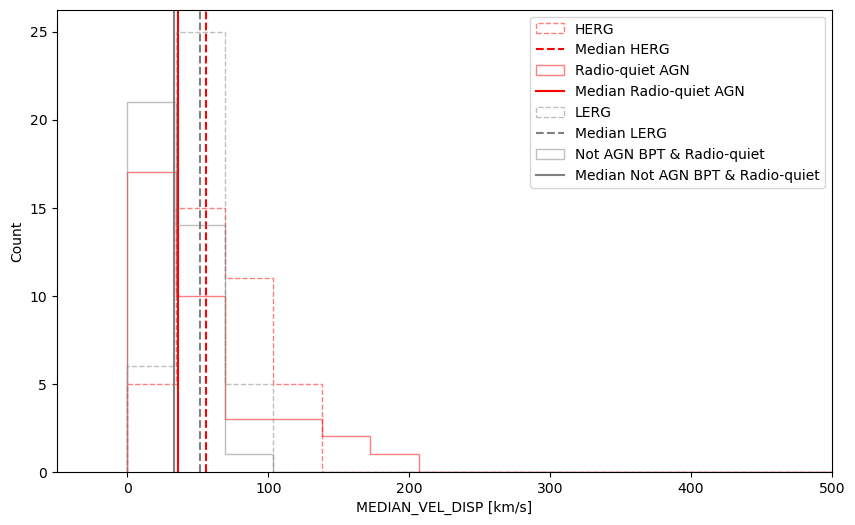

In [52]:
nbins = 30
bins = np.linspace(0, 1000, nbins)

gassig_statistic = 'MEDIAN_VEL_DISP'
alpha = 0.5
plt.figure(figsize=(10,6))

# check valid gassig_statistic for each CATID
reduced_matched_radioAGNsplit_table = matched_radioAGNsplit_table.copy()
valid_catids = gassig_statistics_table['CATID'][~np.isnan(gassig_statistics_table[gassig_statistic])]

mask = []
for row in matched_radioAGNsplit_table:
    row_array = np.array(row.as_void().tolist(), dtype=int)
    mask.append(np.all(np.isin(row_array, valid_catids)))

mask = np.array(mask)
reduced_matched_radioAGNsplit_table = reduced_matched_radioAGNsplit_table[mask]

for source_type, (source_mask, colour, marker, linestyle, point_size) in radiosource_AGN_dict.items():
    catid_col = radiosource_AGN_CATID_dict[source_type]
    plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table[catid_col])][gassig_statistic], 
         color=colour, label = source_type, alpha = alpha, bins=bins, histtype='step', linestyle=linestyle)
    
    plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table[catid_col])][gassig_statistic]), color=colour, linestyle=linestyle, label=f'Median {source_type}')

    
# plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['Radio_NonAGN_CATID'])][gassig_statistic], 
#          color=radioNonAGN_colour, label = 'LERGs', alpha = 0.5, bins=bins, histtype='step')
# plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_AGN_CATID'])][gassig_statistic], 
#          color=nonradioAGN_colour, label = 'Radio-quiet AGN', alpha = 0.5, bins=bins, histtype='step')
# plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_NonAGN_CATID'])][gassig_statistic], 
#          color=nonradioNonAGN_colour, label = 'Not Radio or BPT AGN', alpha = 0.5, bins=bins, histtype='step')



# plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['Radio_AGN_CATID'])][gassig_statistic]), color=radioAGN_colour, linestyle=radiosource_linestyle, label='Median HERGs')
# plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_AGN_CATID'])][gassig_statistic]), color=nonradioAGN_colour, linestyle='-', label='Median Radio-quiet AGN')
# plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioAGNsplit_table['NonRadio_NonAGN_CATID'])][gassig_statistic]), color=nonradioNonAGN_colour, linestyle='-', label='Median Not Radio or BPT AGN')

plt.ylabel('Count')
plt.xlabel('MEDIAN_VEL_DISP [km/s]')
plt.legend()
plt.xlim((-50,500))

plt.show()

In [35]:
SAMI_spectra_table_hdu

CUBEID,CUBEIDPUB,CUBENAME,CATID,Z_SPEC,PIX_1_4_ARCSECOND,AREA_COV_1_4_ARCSECOND,V_GAS_1_4_ARCSECOND,V_GAS_1_4_ARCSECOND_ERR,VDISP_GAS_1_4_ARCSECOND,VDISP_GAS_1_4_ARCSECOND_ERR,OII3726_1_4_ARCSECOND,OII3726_1_4_ARCSECOND_ERR,OII3729_1_4_ARCSECOND,OII3729_1_4_ARCSECOND_ERR,NEIII3869_1_4_ARCSECOND,NEIII3869_1_4_ARCSECOND_ERR,HEPSILON_1_4_ARCSECOND,HEPSILON_1_4_ARCSECOND_ERR,HDELTA_1_4_ARCSECOND,HDELTA_1_4_ARCSECOND_ERR,HGAMMA_1_4_ARCSECOND,HGAMMA_1_4_ARCSECOND_ERR,OIII4363_1_4_ARCSECOND,OIII4363_1_4_ARCSECOND_ERR,HBETA_1_4_ARCSECOND,HBETA_1_4_ARCSECOND_ERR,OIII5007_1_4_ARCSECOND,OIII5007_1_4_ARCSECOND_ERR,OI6300_1_4_ARCSECOND,OI6300_1_4_ARCSECOND_ERR,HALPHA_1_4_ARCSECOND,HALPHA_1_4_ARCSECOND_ERR,NII6583_1_4_ARCSECOND,NII6583_1_4_ARCSECOND_ERR,SII6716_1_4_ARCSECOND,SII6716_1_4_ARCSECOND_ERR,SII6731_1_4_ARCSECOND,SII6731_1_4_ARCSECOND_ERR,EXT_CORR_1_4_ARCSECOND,EXT_CORR_1_4_ARCSECOND_ERR,SFR_1_4_ARCSECOND,SFR_1_4_ARCSECOND_ERR,NPIX_2_ARCSECOND,AREA_COV_2_ARCSECOND,V_GAS_2_ARCSECOND,V_GAS_2_ARCSECOND_ERR,VDISP_GAS_2_ARCSECOND,VDISP_GAS_2_ARCSECOND_ERR,OII3726_2_ARCSECOND,OII3726_2_ARCSECOND_ERR,OII3729_2_ARCSECOND,OII3729_2_ARCSECOND_ERR,NEIII3869_2_ARCSECOND,NEIII3869_2_ARCSECOND_ERR,HEPSILON_2_ARCSECOND,HEPSILON_2_ARCSECOND_ERR,HDELTA_2_ARCSECOND,HDELTA_2_ARCSECOND_ERR,HGAMMA_2_ARCSECOND,HGAMMA_2_ARCSECOND_ERR,OIII4363_2_ARCSECOND,OIII4363_2_ARCSECOND_ERR,HBETA_2_ARCSECOND,HBETA_2_ARCSECOND_ERR,OIII5007_2_ARCSECOND,OIII5007_2_ARCSECOND_ERR,OI6300_2_ARCSECOND,OI6300_2_ARCSECOND_ERR,HALPHA_2_ARCSECOND,HALPHA_2_ARCSECOND_ERR,NII6583_2_ARCSECOND,NII6583_2_ARCSECOND_ERR,SII6716_2_ARCSECOND,SII6716_2_ARCSECOND_ERR,SII6731_2_ARCSECOND,SII6731_2_ARCSECOND_ERR,EXT_CORR_2_ARCSECOND,EXT_CORR_2_ARCSECOND_ERR,SFR_2_ARCSECOND,SFR_2_ARCSECOND_ERR,NPIX_3_ARCSECOND,AREA_COV_3_ARCSECOND,V_GAS_3_ARCSECOND,V_GAS_3_ARCSECOND_ERR,VDISP_GAS_3_ARCSECOND,VDISP_GAS_3_ARCSECOND_ERR,OII3726_3_ARCSECOND,OII3726_3_ARCSECOND_ERR,OII3729_3_ARCSECOND,OII3729_3_ARCSECOND_ERR,NEIII3869_3_ARCSECOND,NEIII3869_3_ARCSECOND_ERR,HEPSILON_3_ARCSECOND,HEPSILON_3_ARCSECOND_ERR,HDELTA_3_ARCSECOND,HDELTA_3_ARCSECOND_ERR,HGAMMA_3_ARCSECOND,HGAMMA_3_ARCSECOND_ERR,OIII4363_3_ARCSECOND,OIII4363_3_ARCSECOND_ERR,HBETA_3_ARCSECOND,HBETA_3_ARCSECOND_ERR,OIII5007_3_ARCSECOND,OIII5007_3_ARCSECOND_ERR,OI6300_3_ARCSECOND,OI6300_3_ARCSECOND_ERR,HALPHA_3_ARCSECOND,HALPHA_3_ARCSECOND_ERR,NII6583_3_ARCSECOND,NII6583_3_ARCSECOND_ERR,SII6716_3_ARCSECOND,SII6716_3_ARCSECOND_ERR,SII6731_3_ARCSECOND,SII6731_3_ARCSECOND_ERR,EXT_CORR_3_ARCSECOND,EXT_CORR_3_ARCSECOND_ERR,SFR_3_ARCSECOND,SFR_3_ARCSECOND_ERR,NPIX_4_ARCSECOND,AREA_COV_4_ARCSECOND,V_GAS_4_ARCSECOND,V_GAS_4_ARCSECOND_ERR,VDISP_GAS_4_ARCSECOND,VDISP_GAS_4_ARCSECOND_ERR,OII3726_4_ARCSECOND,OII3726_4_ARCSECOND_ERR,OII3729_4_ARCSECOND,OII3729_4_ARCSECOND_ERR,NEIII3869_4_ARCSECOND,NEIII3869_4_ARCSECOND_ERR,HEPSILON_4_ARCSECOND,HEPSILON_4_ARCSECOND_ERR,HDELTA_4_ARCSECOND,HDELTA_4_ARCSECOND_ERR,HGAMMA_4_ARCSECOND,HGAMMA_4_ARCSECOND_ERR,OIII4363_4_ARCSECOND,OIII4363_4_ARCSECOND_ERR,HBETA_4_ARCSECOND,HBETA_4_ARCSECOND_ERR,OIII5007_4_ARCSECOND,OIII5007_4_ARCSECOND_ERR,OI6300_4_ARCSECOND,OI6300_4_ARCSECOND_ERR,HALPHA_4_ARCSECOND,HALPHA_4_ARCSECOND_ERR,NII6583_4_ARCSECOND,NII6583_4_ARCSECOND_ERR,SII6716_4_ARCSECOND,SII6716_4_ARCSECOND_ERR,SII6731_4_ARCSECOND,SII6731_4_ARCSECOND_ERR,EXT_CORR_4_ARCSECOND,EXT_CORR_4_ARCSECOND_ERR,SFR_4_ARCSECOND,SFR_4_ARCSECOND_ERR,NPIX_3KPC_ROUND,AREA_COV_3KPC_ROUND,V_GAS_3KPC_ROUND,V_GAS_3KPC_ROUND_ERR,VDISP_GAS_3KPC_ROUND,VDISP_GAS_3KPC_ROUND_ERR,OII3726_3KPC_ROUND,OII3726_3KPC_ROUND_ERR,OII3729_3KPC_ROUND,OII3729_3KPC_ROUND_ERR,NEIII3869_3KPC_ROUND,NEIII3869_3KPC_ROUND_ERR,HEPSILON_3KPC_ROUND,HEPSILON_3KPC_ROUND_ERR,HDELTA_3KPC_ROUND,HDELTA_3KPC_ROUND_ERR,HGAMMA_3KPC_ROUND,HGAMMA_3KPC_ROUND_ERR,OIII4363_3KPC_ROUND,OIII4363_3KPC_ROUND_ERR,HBETA_3KPC_ROUND,HBETA_3KPC_ROUND_ERR,OIII5007_3KPC_ROUND,OIII5007_3KPC_ROUND_ERR,OI6300_3KPC_ROUND,OI6300_3KPC_ROUND_ERR,HALPHA_3KPC_ROUND,HALPHA_3KPC_ROUND_ERR,NII6583_3KPC_ROUND

In [36]:
ls = gassig_statistics_table['CATID'][gassig_statistics_table['MEDIAN_VEL_DISP'] > 400]  # Example condition to filter CATIDs
print(list(ls))

[np.int64(214250)]


In [37]:
test_dict = {1: 2, 2: 3, 3: 4}

print(test_dict.items())

dict_items([(1, 2), (2, 3), (3, 4)])


In [38]:
z= 0.053
6564.61 * (1 + z)

6912.5343299999995

## LINER (radio-quiet) v LINER (radio-loud) v NonRadio_NonAGN

Number of valid radioLINERHs: 18
Number of valid nonradioLINERs: 147
Number of valid Radio-quiet AGN: 106
Number of valid not radio or BPT AGN: 2172


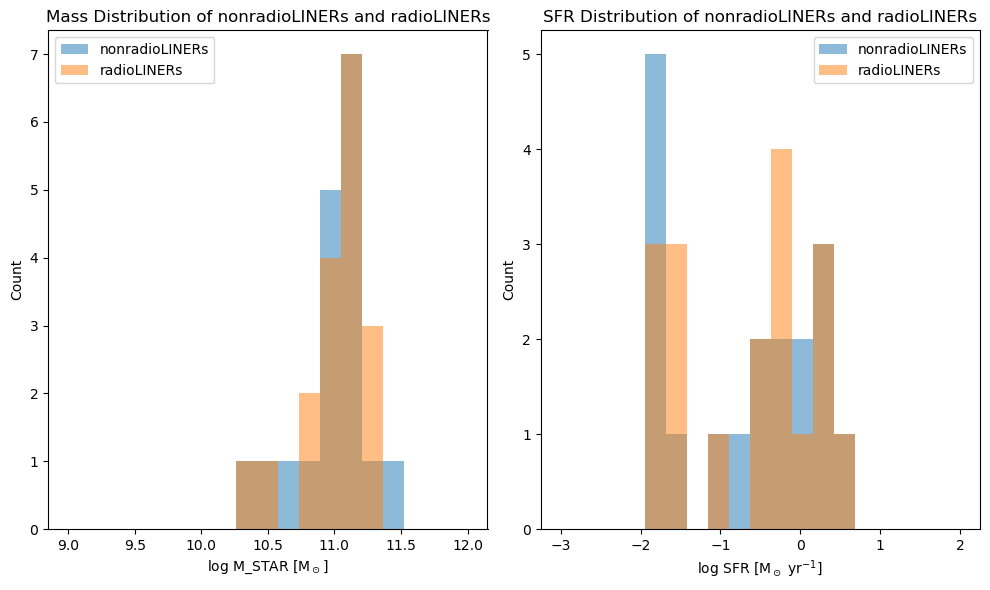

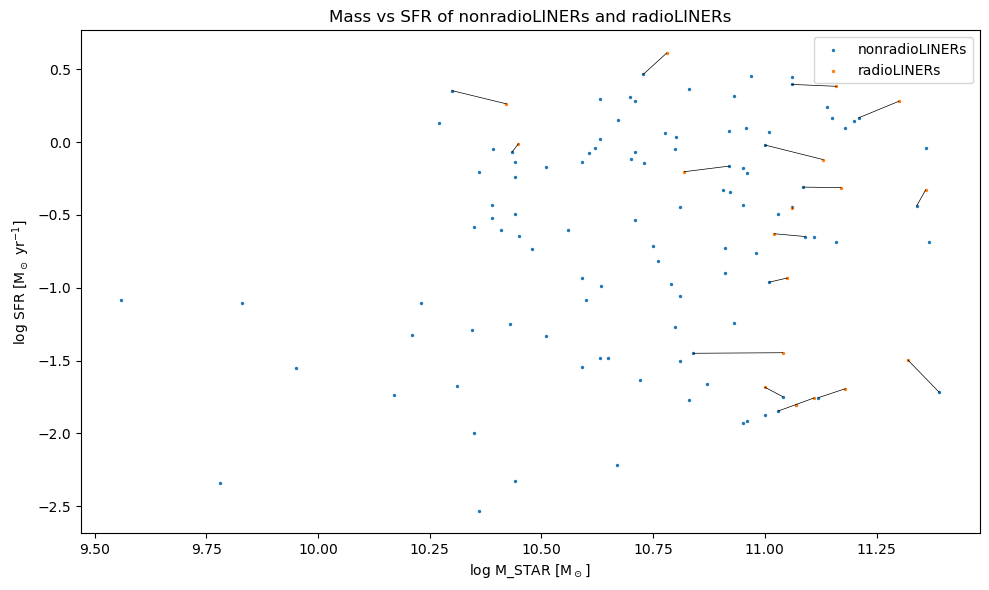

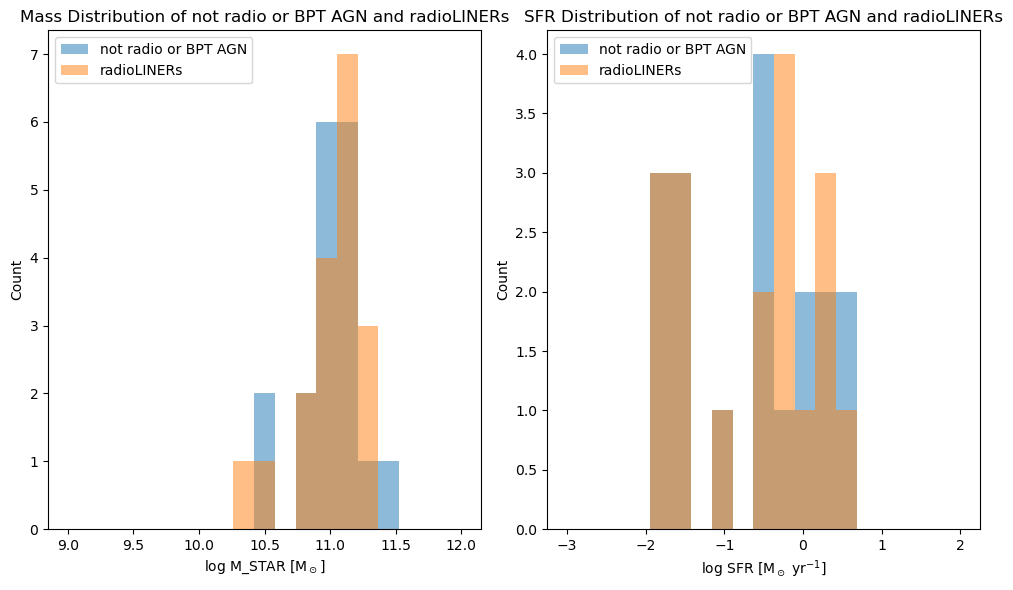

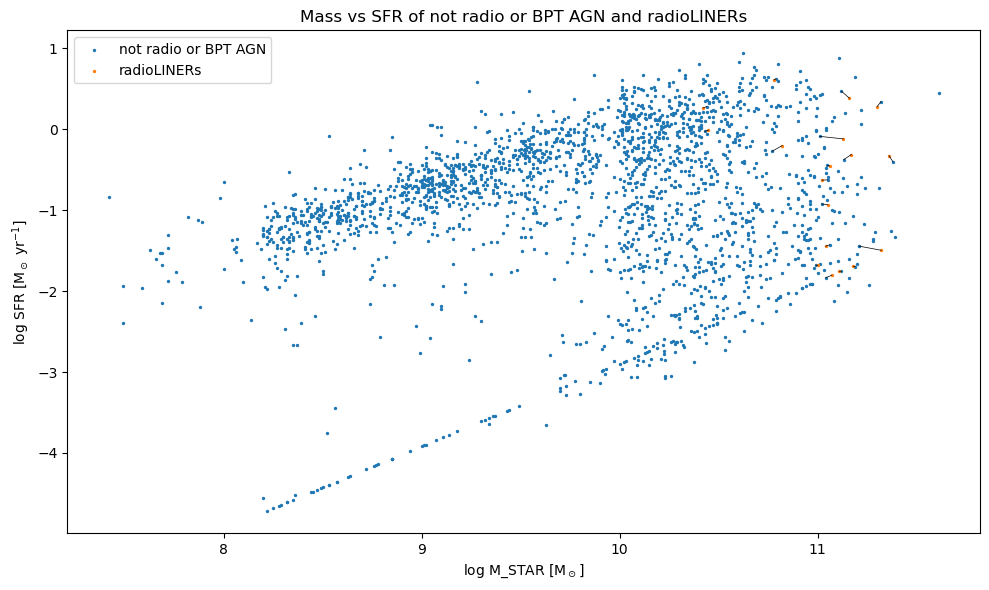

Radio_LINER_CATID,NonRadio_LINER_CATID,NonRadio_NonAGN_CATID
int64,int64,int64
7839,388552,136605
23623,551505,184042
41059,422291,599834
54918,22595,383147
55143,594049,388146
56140,560883,396781
185914,85505,239109
209680,186012,347432
238211,99428,22582


In [39]:
refresh_module()
show_plots = True


valid_radioLINER_CATIDs = valid_Summary_table_hdu['CATID'][valid_LINER_mask & valid_radiosource_mask]
valid_nonradioLINER_CATIDs = valid_Summary_table_hdu['CATID'][valid_LINER_mask & ~valid_radiosource_mask]
valid_nonRadioNonAGN_CATIDs = valid_Summary_table_hdu['CATID'][~valid_AGN_mask & ~valid_radiosource_mask]


print(f"Number of valid radioLINERHs: {len(valid_radioLINER_CATIDs)}")
print(f"Number of valid nonradioLINERs: {len(valid_radioNonAGN_CATIDs)}")
print(f"Number of valid Radio-quiet AGN: {len(valid_nonradioLINER_CATIDs)}")
print(f"Number of valid not radio or BPT AGN: {len(valid_nonRadioNonAGN_CATIDs)}")



matched_radioLINER_to_nonradioLINER = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_radioLINER_CATIDs, valid_nonradioLINER_CATIDs, distribution_plots=show_plots, labels=('nonradioLINERs', 'radioLINERs'), scatter_plot=show_plots)
matched_radioLINER_to_nonradioLINER.rename_columns(['Input_CATID', 'Matched_CATID'], ['Radio_LINER_CATID', 'NonRadio_LINER_CATID'])
matched_radioLINER_to_nonradioLINER.remove_column('min_diff')


matched_radioLINER_to_nonRadioNonAGN  = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_radioLINER_CATIDs, valid_nonRadioNonAGN_CATIDs, distribution_plots=show_plots, labels=('not radio or BPT AGN', 'radioLINERs'), scatter_plot=show_plots)
matched_radioLINER_to_nonRadioNonAGN.rename_columns(['Input_CATID', 'Matched_CATID'], ['Radio_LINER_CATID', 'NonRadio_NonAGN_CATID'])
matched_radioLINER_to_nonRadioNonAGN.remove_column('min_diff')
# combine into one table

matched_radioLINERsplit_table = join(matched_radioLINER_to_nonradioLINER, matched_radioLINER_to_nonRadioNonAGN, keys = 'Radio_LINER_CATID', join_type = 'left', table_names = ['1', '2'])

radiosource_LINER_CATID_dict ={ 'Radio-loud LINER': 'Radio_LINER_CATID',
                        'Radio-quiet LINER': 'NonRadio_LINER_CATID',
                        'Not AGN BPT & Radio-quiet': 'NonRadio_NonAGN_CATID'}

matched_radioLINERsplit_table



### Median GASSIG Histograms

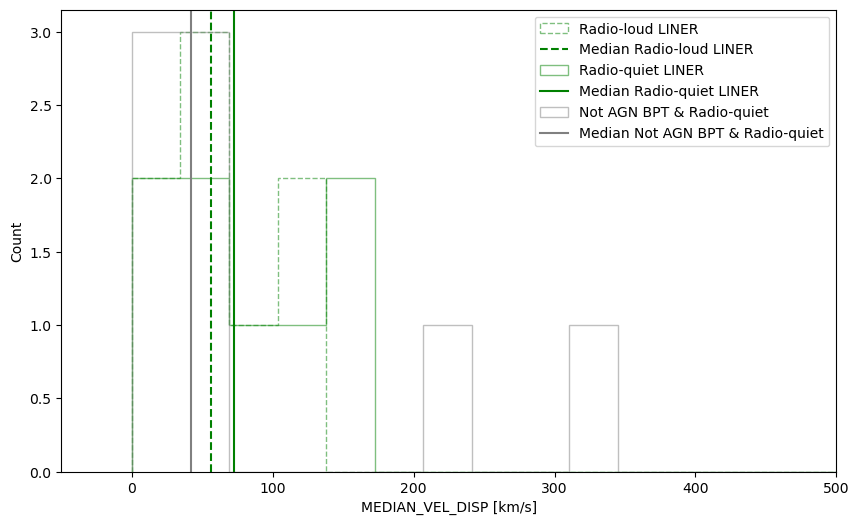

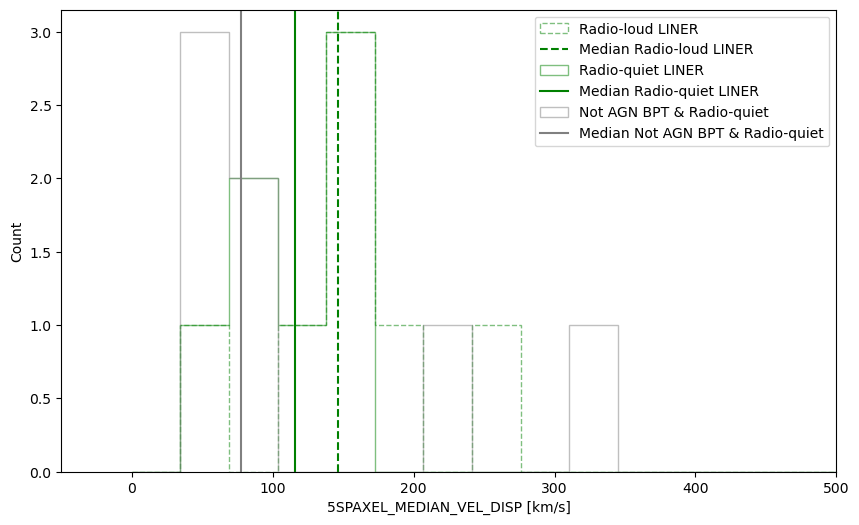

In [40]:

nbins = 30
bins = np.linspace(0, 1000, nbins)
alpha = 0.5

for gassig_statistic in ('MEDIAN_VEL_DISP', '5SPAXEL_MEDIAN_VEL_DISP'):
    plt.figure(figsize=(10,6))

    # check valid gassig_statistic for each CATID
    reduced_matched_radioLINERsplit_table = matched_radioLINERsplit_table.copy()
    valid_catids = gassig_statistics_table['CATID'][~np.isnan(gassig_statistics_table[gassig_statistic])]

    mask = []
    for row in matched_radioLINERsplit_table:
        row_array = np.array(row.as_void().tolist(), dtype=int)
        mask.append(np.all(np.isin(row_array, valid_catids)))

    mask = np.array(mask)
    reduced_matched_radioLINERsplit_table = reduced_matched_radioLINERsplit_table[mask]

    for source_type, (source_mask, colour, marker, linestyle, point_size) in radiosource_LINER_dict.items():
        catid_col = radiosource_LINER_CATID_dict[source_type]
        plt.hist(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioLINERsplit_table[catid_col])][gassig_statistic], 
            color=colour, label = source_type, alpha = alpha, bins=bins, histtype='step', linestyle=linestyle, lw=100)
        
        plt.axvline(np.nanmedian(gassig_statistics_table[np.isin(gassig_statistics_table['CATID'], reduced_matched_radioLINERsplit_table[catid_col])][gassig_statistic]), 
                    color=colour, linestyle=linestyle, label=f'Median {source_type}')

        
    plt.ylabel('Count')
    plt.xlabel(f'{gassig_statistic} [km/s]')
    plt.legend()
    plt.xlim((-50,500))

    plt.show()



### Median GASSIG v M_STAR

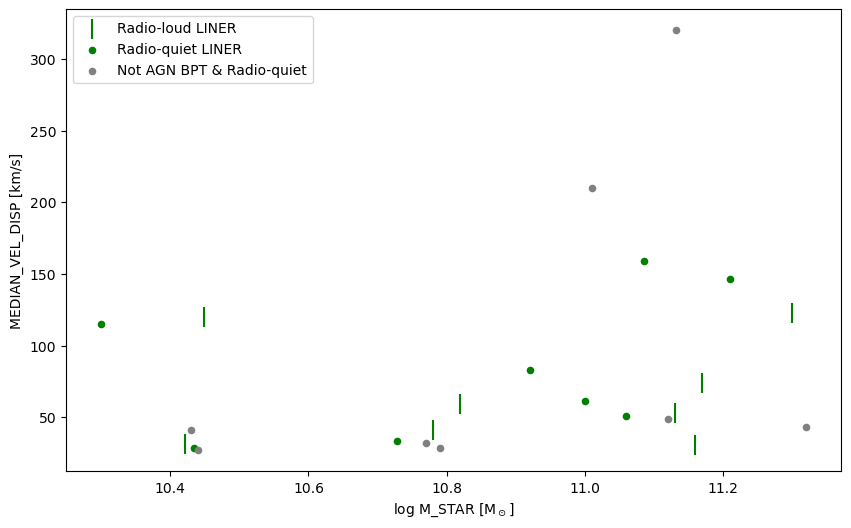

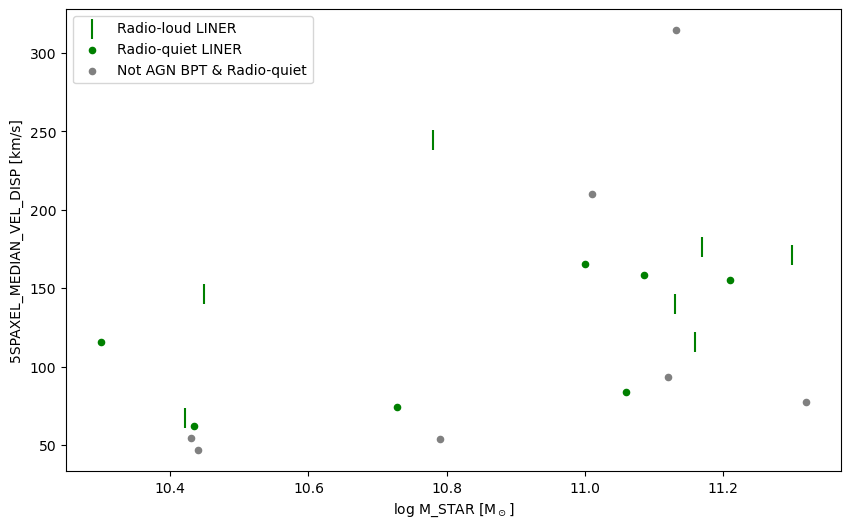

In [41]:
nbins = 30
bins = np.linspace(0, 1000, nbins)
alpha = 0.5

for gassig_statistic in ('MEDIAN_VEL_DISP', '5SPAXEL_MEDIAN_VEL_DISP'):
    plt.figure(figsize=(10,6))

    # check valid gassig_statistic for each CATID
    reduced_matched_radioLINERsplit_table = matched_radioLINERsplit_table.copy()
    valid_catids = gassig_statistics_table['CATID'][~np.isnan(gassig_statistics_table[gassig_statistic])]

    mask = []
    for row in matched_radioLINERsplit_table:
        row_array = np.array(row.as_void().tolist(), dtype=int)
        mask.append(np.all(np.isin(row_array, valid_catids)))

    mask = np.array(mask)
    reduced_matched_radioLINERsplit_table = reduced_matched_radioLINERsplit_table[mask]

    for source_type, (source_mask, colour, marker, linestyle, point_size) in radiosource_LINER_dict.items():
        catid_col = radiosource_LINER_CATID_dict[source_type]
        plt.scatter(joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], reduced_matched_radioLINERsplit_table[catid_col])]['M_STAR'], 
                joined_gassig_summary_table[np.isin(joined_gassig_summary_table['CATID'], reduced_matched_radioLINERsplit_table[catid_col])][gassig_statistic], 
                color=colour, marker= marker, label = source_type, s =point_size*10)
        
    plt.xlabel('log M_STAR [M$_\\odot$]')
    plt.ylabel(f'{gassig_statistic} [km/s]')
    plt.legend()
    plt.show()